# One Feature Model Scores LB 0.930!
In this notebook, we will explore the Kaggle Ion Comp data and explore a one feature model. The LB result of 0.930 is enlightening.

Here we manually remove signal drift. Note that it is better to use machine learning to remove drift, but doing it by hand once allows us to understand its nature and build better models later.

# Load Libraries and Data

In [197]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
from sklearn.metrics import f1_score
#import graphviz
from tqdm import tqdm
from scipy import signal
from sklearn import tree
import lightgbm as lgb
import optuna
import warnings
warnings.filterwarnings('ignore')

In [131]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
train.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


# Description of Data
The training data is recordings in time. At each 10,000th of a second, the strength of the signal was recorded and the number of ion channels open was recorded. It is our task to build a model that predicts the number of open channels from signal at each time step. Furthermore we are told that the data was recorded in batches of 50 seconds. Therefore each 500,000 rows is one batch. The training data contains 10 batches and the test data contains 4 batches. Let's display the number of open channels and signal strength together for each training batch.

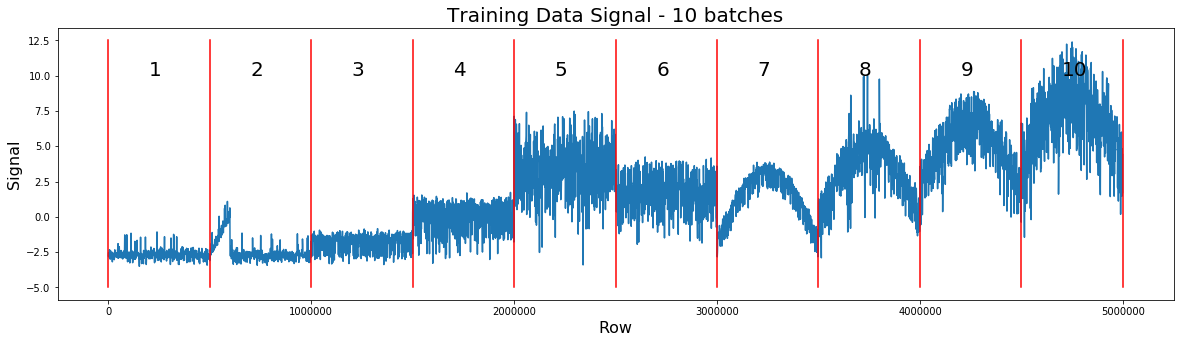

In [132]:
plt.figure(figsize=(20,5)); res = 1000
plt.plot(range(0,train.shape[0],res),train.signal[0::res])
for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('Training Data Signal - 10 batches',size=20)
plt.show()

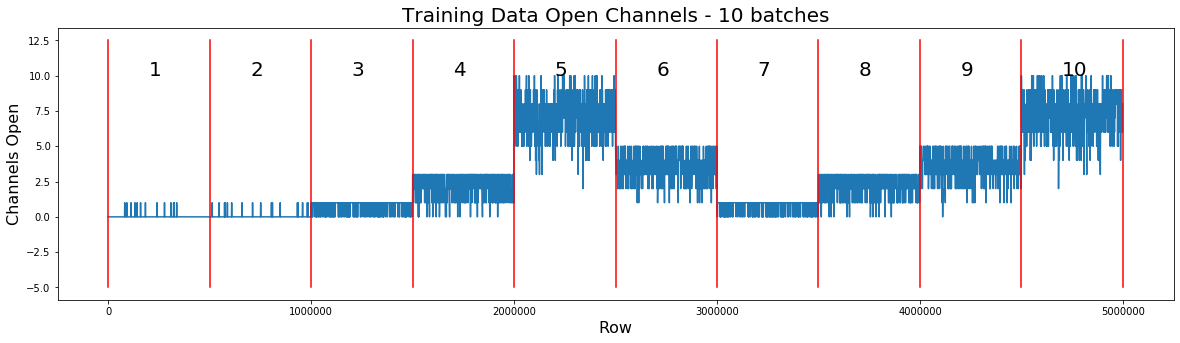

In [133]:
plt.figure(figsize=(20,5)); res = 1000
plt.plot(range(0,train.shape[0],res),train.open_channels[0::res])
for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Channels Open',size=16); 
plt.title('Training Data Open Channels - 10 batches',size=20)
plt.show()

## Reflection
From the plots above, it looks like they used 5 different synthetic models. One model produced maximum 1 channel open with low probability (batches 1 and 2). One model produced maximum 1 channel open with high probability (batches 3 and 7). One model produced maximum 3 channels open (batches 4 and 8). One model produced maximum 5 channels open (batches 6 and 9) and one model produced maximum 10 channels open (batches 5 and 10). Furthermore drift was added to batches 7, 8, 9, 10. And the beginning of batch 2.

According to the paper [here][1], the data is synthesized. Also "electrophysiological" noise and drift were added. Drift is a signal bias causing the signal to no longer be a horizontal line like batches 2, 7, 8, 9, 10 above.

> Data description and dataset construction. Ion channel dwell-times were
simulated using the method of Gillespie 43 from published single channel models.
Channels are assumed to follow a stochastic Markovian process and transition
from one state to the next simulated by randomly sampling from a lifetime
probability distribution calculated for each state. Authentic “electrophysiological”
noise was added to these events by passing the signal through a patch-clamp
amplifier and recording it back to file with CED’s Signal software via an Axon
electronic “model cell”. In some datasets additional drift was applied to the final
data with Matlab. Two different stochastic gating models, (termed M1 and M2)
were used to generate semi-synthetic ion channel data. M1 is a low open probability model from ref. 41 (Fig. 3a, b), typically no more than one ion channel opens
simultaneously. Model M2 is from refs. 42,44 and has a much higher open probability (Fig. 3c, d), consequently up to five channels opened simultaneously and there are few instances of zero channels open.


[1]: https://www.nature.com/articles/s42003-019-0729-3


# Correlation Between Signal and Open Channels
Let's look closely at random intervals of signal and open channels to observe how they relate. We notice that they are highly correlated and move up and down together. Therefore we can probabily predict open channels from the one feature signal. The only complication is the synthetic drift that was added. So we will remove it.

#########################
### Random 4357682 to 4362682
#########################


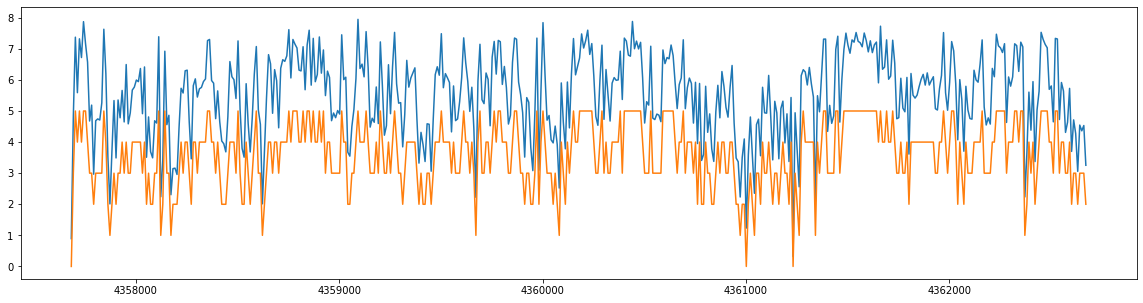

#########################
### Random 1779328 to 1784328
#########################


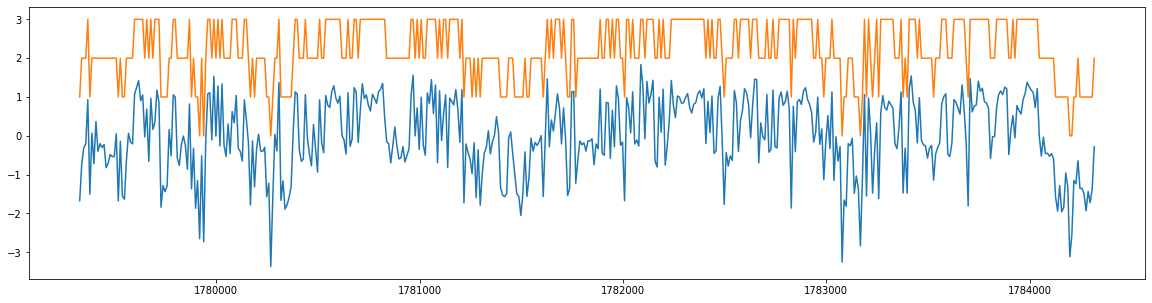

#########################
### Random 2590088 to 2595088
#########################


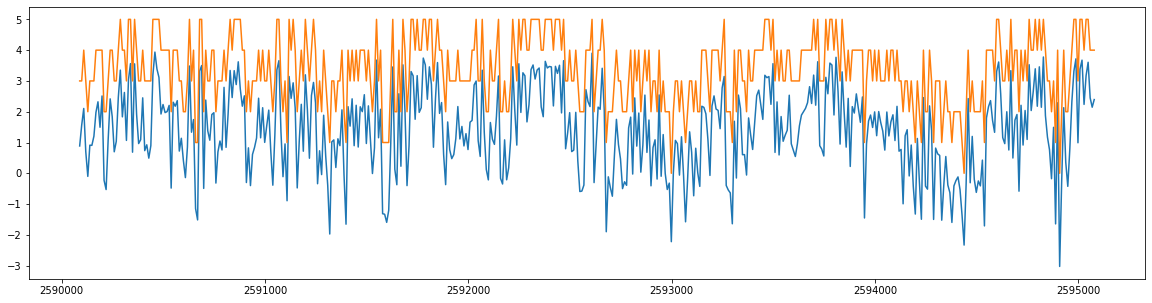

#########################
### Random 528928 to 533928
#########################


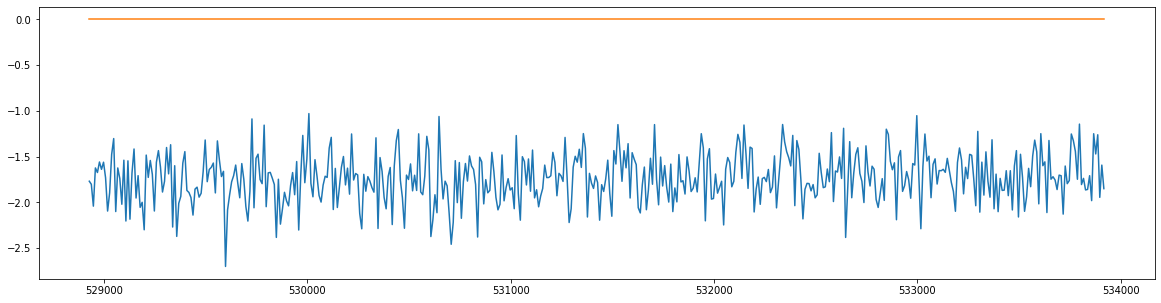

#########################
### Random 4112884 to 4117884
#########################


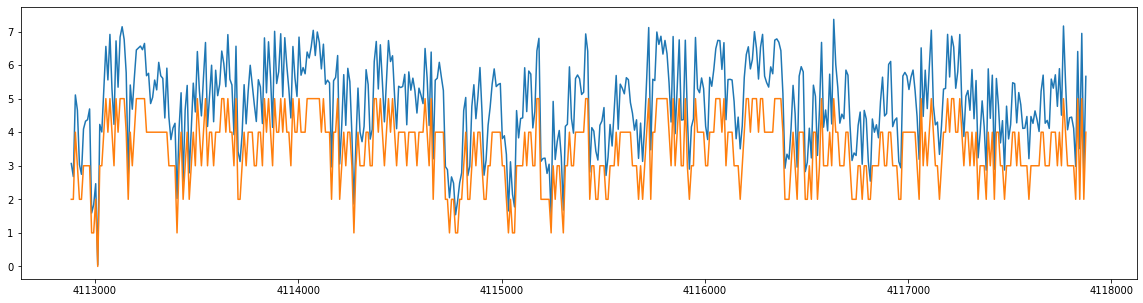

#########################
### Random 1082732 to 1087732
#########################


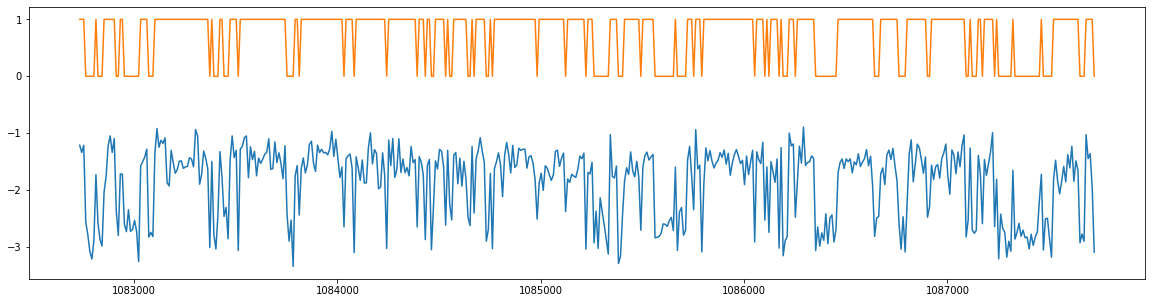

#########################
### Random 2031499 to 2036499
#########################


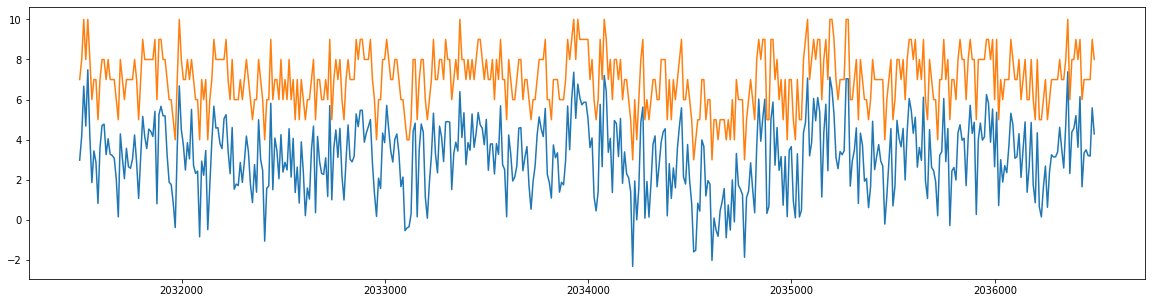

#########################
### Random 482748 to 487748
#########################


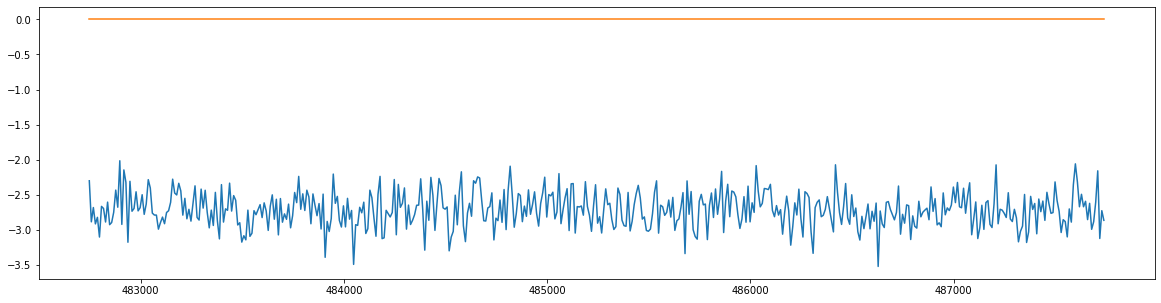

#########################
### Random 2528419 to 2533419
#########################


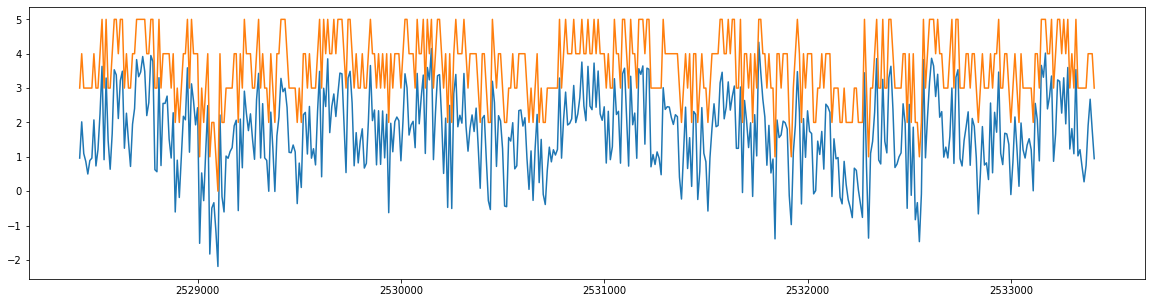

#########################
### Random 2877368 to 2882368
#########################


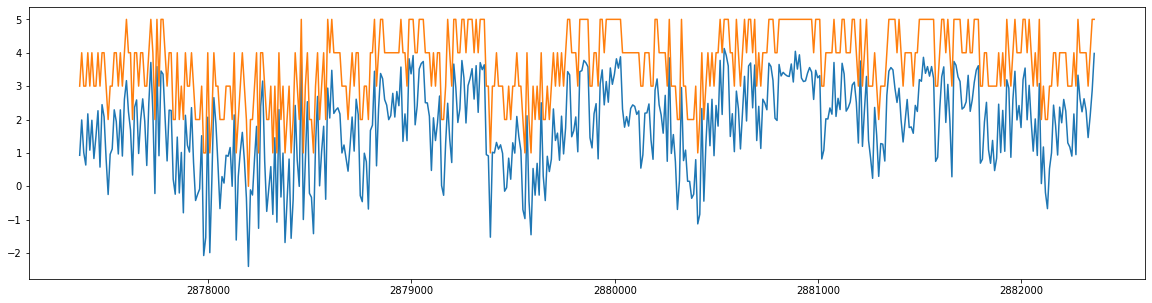

In [134]:
for k in range(10):
    a = int( np.random.uniform(0,train.shape[0]-50000) )
    b=a+5000; res=10
    print('#'*25)
    print('### Random %i to %i'%(a,b))
    print('#'*25)
    plt.figure(figsize=(20,5))
    plt.plot(range(a,b,res),train.signal[a:b][0::res])
    plt.plot(range(a,b,res),train.open_channels[a:b][0::res])
    plt.show()

# Test Data
Let's display the test data signal

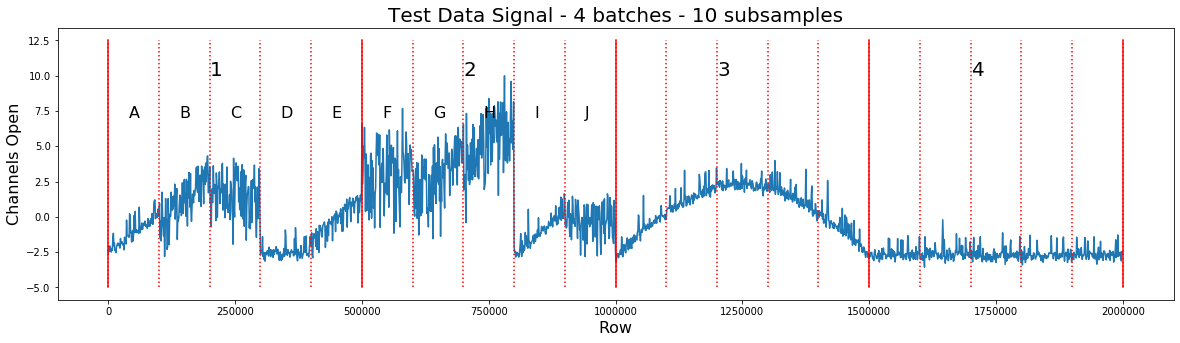

In [135]:
plt.figure(figsize=(20,5))
res = 1000; let = ['A','B','C','D','E','F','G','H','I','J']
plt.plot(range(0,test.shape[0],res),test.signal[0::res])
for i in range(5): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(21): plt.plot([j*100000,j*100000],[-5,12.5],'r:')
for k in range(4): plt.text(k*500000+200000,10,str(k+1),size=20)
for k in range(10): plt.text(k*100000+40000,7,let[k],size=16)
plt.xlabel('Row',size=16); plt.ylabel('Channels Open',size=16); 
plt.title('Test Data Signal - 4 batches - 10 subsamples',size=20)
plt.show()

## Reflection
From this plot we can locate the 5 models in action. And we can recognize the added drift. Batch 1 appears to be 5 subsamples where A, B, C, D, E were created by models 1s, 3, 5, 1s, 1f respectively. Model 1s is the model with maximum 1 channel open with low prob. Model 1f is the model with maximum 1 channel open with high prob. And models 3, 5, 10 are models with maximum 3, 5, 10 channels respectively. We observe slant drift in subsamples A, B, E, G, H, I. We observe parabola draft in batch 3. 

# Remove Training Data Drift
This is a demonstration to show slant drift removal. We could also remove the parabolic drift in batches 7, 8, 9, 10 if we wanted. Below we will only train our models with batches 1, 3, 4, 5, 6. But after removing training drift, we can include the data from batches 2, 7, 8, 9, 10 in our training if we want.

In [136]:
train2 = train.copy()

a=500000; b=600000 # CLEAN TRAIN BATCH 2
train2.loc[train.index[a:b],'signal'] = train2.signal[a:b].values - 3*(train2.time.values[a:b] - 50)/10.

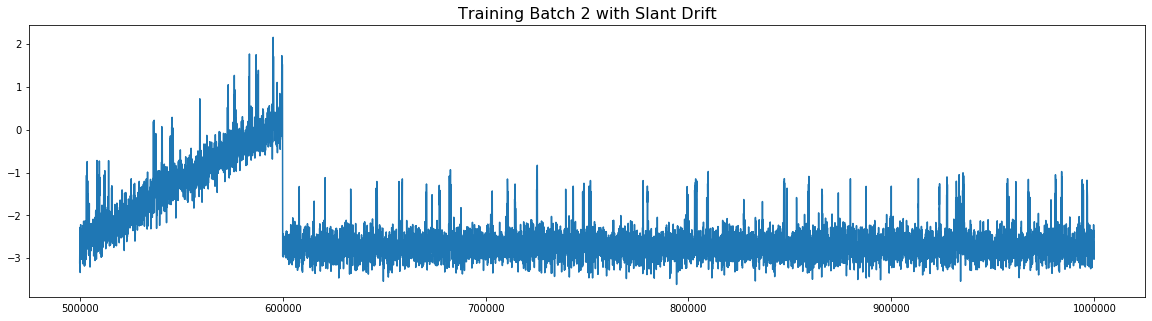

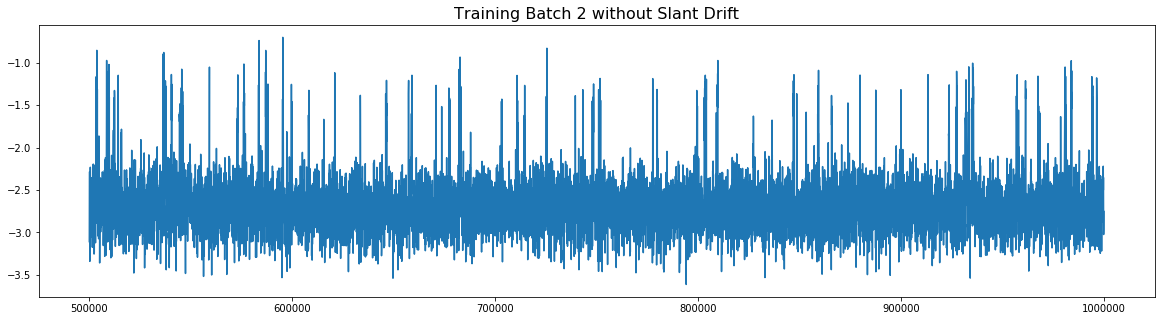

In [137]:
batch=2; a=500000*(batch-1); b=500000*batch; res=50
plt.figure(figsize=(20,5))
plt.plot(range(a,b,res),train.signal[a:b][0::res])
plt.title('Training Batch 2 with Slant Drift',size=16)
plt.figure(figsize=(20,5))
plt.plot(range(a,b,res),train2.signal[a:b][0::res])
plt.title('Training Batch 2 without Slant Drift',size=16)
plt.show()

In [138]:
def f(x,low,high,mid): return -((-low+high)/625)*(x-mid)**2+high -low

# CLEAN TRAIN BATCH 7
batch = 7; a = 500000*(batch-1); b = 500000*batch
train2.loc[train2.index[a:b],'signal'] = train.signal.values[a:b] - f(train.time[a:b].values,-1.817,3.186,325)
# CLEAN TRAIN BATCH 8
batch = 8; a = 500000*(batch-1); b = 500000*batch
train2.loc[train2.index[a:b],'signal'] = train.signal.values[a:b] - f(train.time[a:b].values,-0.094,4.936,375)
# CLEAN TRAIN BATCH 9
batch = 9; a = 500000*(batch-1); b = 500000*batch
train2.loc[train2.index[a:b],'signal'] = train.signal.values[a:b] - f(train.time[a:b].values,1.715,6.689,425)
# CLEAN TRAIN BATCH 10
batch = 10; a = 500000*(batch-1); b = 500000*batch
train2.loc[train2.index[a:b],'signal'] = train.signal.values[a:b] - f(train.time[a:b].values,3.361,8.45,475)

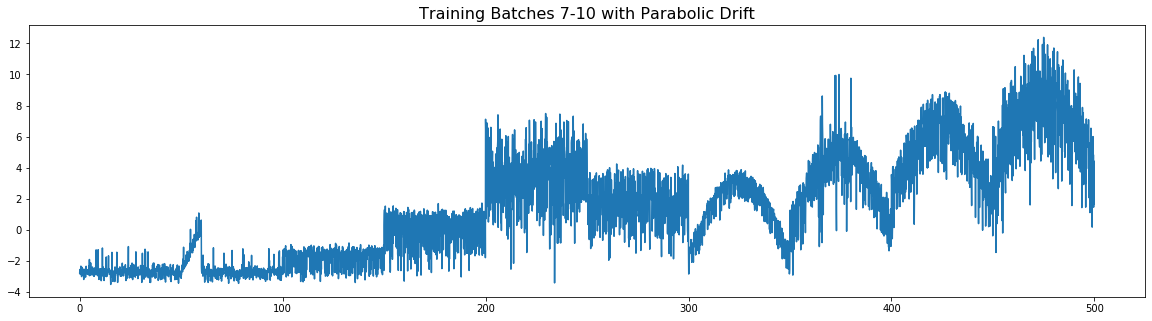

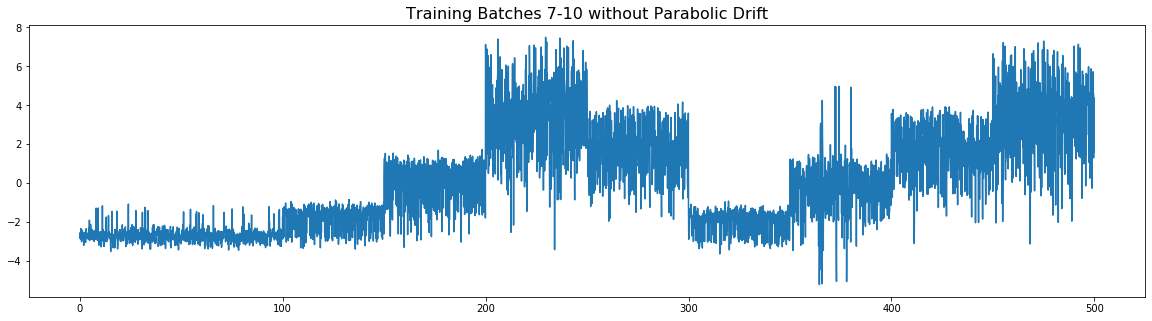

In [139]:
plt.figure(figsize=(20,5))
plt.plot(train.time[::1000],train.signal[::1000])
plt.title('Training Batches 7-10 with Parabolic Drift',size=16)
plt.figure(figsize=(20,5))
plt.plot(train2.time[::1000],train2.signal[::1000])
plt.title('Training Batches 7-10 without Parabolic Drift',size=16)
plt.show()

In [226]:
test2 = pd.read_csv('./data-without-drift/test_clean.csv')
train2 = pd.read_csv('./data-without-drift/train_clean.csv')
train2.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


# Feature engineering

In [140]:
def calc_gradients(s, n_grads=4):
    '''
    Calculate gradients for a pandas series. Returns the same number of samples
    '''
    grads = pd.DataFrame()
    
    g = s.values
    for i in range(n_grads):
        g = np.gradient(g)
        grads['grad_' + str(i+1)] = g
        
    return grads

In [80]:
def calc_low_pass(s, n_filts=10):
    '''
    Applies low pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.3, n_filts)
    
    low_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='low')
        zi = signal.lfilter_zi(b, a)
        low_pass['lowpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        low_pass['lowpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return low_pass

In [81]:
def calc_high_pass(s, n_filts=10):
    '''
    Applies high pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.1, n_filts)
    
    high_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='high')
        zi = signal.lfilter_zi(b, a)
        high_pass['highpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        high_pass['highpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return high_pass

In [182]:
def calc_roll_stats(s, windows=[10, 50, 100, 500, 1000]):
    '''
    Calculates rolling stats like mean, std, min, max...
    '''
    roll_stats = pd.DataFrame()
    for w in windows:
        roll_stats['roll_mean_' + str(w)] = s.rolling(window=w, min_periods=1).mean()
        roll_stats['roll_std_' + str(w)] = s.rolling(window=w, min_periods=1).std()
        roll_stats['roll_min_' + str(w)] = s.rolling(window=w, min_periods=1).min()
        roll_stats['roll_max_' + str(w)] = s.rolling(window=w, min_periods=1).max()
        roll_stats['roll_range_' + str(w)] = roll_stats['roll_max_' + str(w)] - roll_stats['roll_min_' + str(w)]
        roll_stats['roll_mean_s_' + str(w)] = s.rolling(window=w, min_periods=1).mean().shift(-w)
        roll_stats['roll_std_s_' + str(w)] = s.rolling(window=w, min_periods=1).std().shift(-w)
        roll_stats['roll_min_s_' + str(w)] = s.rolling(window=w, min_periods=1).min().shift(-w)
        roll_stats['roll_max_s_' + str(w)] = s.rolling(window=w, min_periods=1).max().shift(-w)
        roll_stats['roll_range_s_' + str(w)] = roll_stats['roll_max_s_' + str(w)] - roll_stats['roll_min_s_' + str(w)]
        roll_stats['roll_min_abs_' + str(w)] = s.rolling(window=2*w, min_periods=1).min().abs().shift(-w)
        roll_stats['roll_range_sbs_' + str(w)] = roll_stats['roll_max_' + str(w)] - roll_stats['roll_min_abs_' + str(w)].shift(-w)
        roll_stats['roll_q10_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.10)
        roll_stats['roll_q25_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.25)
        roll_stats['roll_q50_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.50)
        roll_stats['roll_q75_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.75)
        roll_stats['roll_q90_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.90)
        roll_stats['mean_abs_chg' + str(w)] = roll_stats.apply(lambda x: np.mean(np.abs(np.diff(x))))
        #roll_stats['roll_diff_' + str(w)] = s - roll_stats['roll_mean_' + str(w)]
    
    # add zeros when na values (std)
    roll_stats = roll_stats.fillna(value=0)
             
    return roll_stats

In [83]:
def calc_ewm(s, windows=[10, 50, 100, 500, 1000]):
    '''
    Calculates exponential weighted functions
    '''
    ewm = pd.DataFrame()
    for w in windows:
        ewm['ewm_mean_' + str(w)] = s.ewm(span=w, min_periods=1).mean()
        ewm['ewm_std_' + str(w)] = s.ewm(span=w, min_periods=1).std()
        
    # add zeros when na values (std)
    ewm = ewm.fillna(value=0)
        
    return ewm

In [142]:
def add_features(s):
    '''
    All calculations together
    '''
    
    gradients = calc_gradients(s)
    low_pass = calc_low_pass(s)
    high_pass = calc_high_pass(s)
    roll_stats = calc_roll_stats(s)
    ewm = calc_ewm(s)
    
    return pd.concat([s, gradients, low_pass, high_pass, roll_stats, ewm], axis=1)


def divide_and_add_features(s, signal_size=500000):
    '''
    Divide the signal in bags of "signal_size".
    Normalize the data dividing it by 15.0
    '''
    # normalize
    s = s/15.0
    
    ls = []
    for i in tqdm(range(int(s.shape[0]/signal_size))):
        sig = s[i*signal_size:(i+1)*signal_size].copy().reset_index(drop=True)
        sig_featured = add_features(sig)
        ls.append(sig_featured)
    
    df = pd.concat(ls, axis=0)
    df['signal_shift_+1'] = [0,] + list(df['signal'].values[:-1])
    df['signal_shift_-1'] = list(df['signal'].values[1:]) + [0]
    df['signal_shift_+2'] = [0,] + [1,] + list(df['signal'].values[:-2])
    df['signal_shift_-2'] = list(df['signal'].values[2:]) + [0] + [1]
    df['signal_shift_+3'] = [0,] + [1,] + [1,] + list(df['signal'].values[:-3])
    df['signal_shift_-3'] = list(df['signal'].values[3:]) + [0] + [1] + [2]
    return df

In [130]:
train2.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [227]:
df = divide_and_add_features(train2['signal'])
df.head()

100%|██████████| 10/10 [02:14<00:00, 13.42s/it]


,signal,grad_1,grad_2,grad_3,grad_4,lowpass_lf_0.0100,lowpass_ff_0.0100,lowpass_lf_0.0154,lowpass_ff_0.0154,lowpass_lf_0.0239,...,ewm_mean_500,ewm_std_500,ewm_mean_1000,ewm_std_1000,signal_shift_+1,signal_shift_-1,signal_shift_+2,signal_shift_-2,signal_shift_+3,signal_shift_-3
0,-0.184000,-0.006380,0.018133,-0.019688,0.001474,-0.184000,-0.186104,-0.184000,-0.186360,-0.184000,...,-0.184000,0.000000,-0.184000,0.000000,0.000000,-0.190380,0.000000,-0.160493,0.00000,-0.209360
1,-0.190380,0.011753,-0.001555,-0.018214,0.013497,-0.184099,-0.186085,-0.184151,-0.186375,-0.184231,...,-0.187196,0.004511,-0.187193,0.004511,-0.184000,-0.160493,1.000000,-0.209360,1.00000,-0.210167
2,-0.160493,-0.009490,-0.018295,0.007305,0.018674,-0.183831,-0.186072,-0.183738,-0.186402,-0.183595,...,-0.178260,0.015758,-0.178275,0.015749,-0.190380,-0.209360,-0.184000,-0.210167,1.00000,-0.176120
3,-0.209360,-0.024837,0.013055,0.019133,-0.008792,-0.183865,-0.186064,-0.183795,-0.186444,-0.183691,...,-0.186082,0.020199,-0.186070,0.020180,-0.160493,-0.210167,-0.190380,-0.176120,-0.18400,-0.179953
4,-0.210167,0.016620,0.019972,-0.010280,-0.016318,-0.184666,-0.186045,-0.185025,-0.186460,-0.185576,...,-0.190937,0.020545,-0.190909,0.020533,-0.209360,-0.176120,-0.160493,-0.179953,-0.19038,-0.172900


# Make Five LGBM Models
We will make one model for each different type of signal we observed above.

In [228]:
seed = 30

In [229]:
params = {
    'num_leaves': 128,
    'min_child_weight': 0.01,
    #'min_child_samples': 40,
    #'feature_fraction': max(0.1, np.sqrt(n_features)/n_features),
    'bagging_fraction': 0.9,
    'min_data_in_leaf': 50,
    'objective': 'binary',
    'max_depth': 70,
    'learning_rate': 0.02,
    "boosting_type": "gbdt",
    "bagging_seed": seed,
    "metric": 'auc',
    "verbosity": -1,
    'lambda_l1': 2.95,
    'lambda_l2': 1.33,
    'random_state': seed,
    'colsample_bytree': 0.686
    }

In [93]:
def macro_f1_score(preds, data):
    y_true = data.get_label()
    #N_LABELS = 2
    #reshaped_preds = preds.reshape(N_LABELS, len(preds) // N_LABELS)
    #y_pred = np.argmax(reshaped_preds, axis=0)
    y_pred = np.round(preds).astype(int)
    
    score = f1_score(y_true, y_pred, average='macro')
    return 'f1_score', score, True

## 1 Slow Open Channel

In [230]:
batch = 1; a = 500000*(batch-1); b = 500000*batch
batch = 2; c = 500000*(batch-1); d = 500000*batch

X_train = df[a:b]
y_train = train2.open_channels.values[a:b]
X_valid = df[c:d]
y_valid = train2.open_channels.values[c:d]

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

#clf1s = tree.DecisionTreeClassifier(max_depth=1)
#clf1s = clf1s.fit(X_train,y_train)

clf = lgb.train(params, train_data, 1000, valid_sets=valid_data, verbose_eval=10, early_stopping_rounds=20)

print('Training model 1s channel')
#preds = clf1s.predict(X_train)
preds_p = clf.predict(X_valid, num_iteration=clf.best_iteration)
preds = np.round(preds_p).astype(int)
#preds = np.argmax(preds_p, axis=1)
score_1s = f1_score(y_valid,preds,average='macro')
print('has f1 validation score =', score_1s)

# construct using all samples
X_train_all = np.concatenate([df[a:b],df[c:d]])
y_train_all = np.concatenate([train2.open_channels.values[a:b],train2.open_channels.values[c:d]]).reshape((-1,1))

clf1s = lgb.LGBMClassifier(**params, num_boost_round=clf.best_iteration * 2)
clf1s.fit(X_train_all, y_train_all)

"""
tree_graph = tree.export_graphviz(clf1s, out_file=None, max_depth = 10,
    impurity = False, feature_names = ['signal'], class_names = ['0', '1'],
    rounded = True, filled= True )
graphviz.Source(tree_graph)
"""

Training until validation scores don't improve for 20 rounds
[10]	valid_0's auc: 0.999551
[20]	valid_0's auc: 0.999704
[30]	valid_0's auc: 0.999861
[40]	valid_0's auc: 0.999912
[50]	valid_0's auc: 0.999916
[60]	valid_0's auc: 0.99997
[70]	valid_0's auc: 0.999971
[80]	valid_0's auc: 0.999972
[90]	valid_0's auc: 0.999973
[100]	valid_0's auc: 0.999977
[110]	valid_0's auc: 0.999978
[120]	valid_0's auc: 0.999982
[130]	valid_0's auc: 0.999983
[140]	valid_0's auc: 0.999983
[150]	valid_0's auc: 0.999987
[160]	valid_0's auc: 0.999988
[170]	valid_0's auc: 0.999988
[180]	valid_0's auc: 0.999988
[190]	valid_0's auc: 0.999988
[200]	valid_0's auc: 0.999988
[210]	valid_0's auc: 0.999988
[220]	valid_0's auc: 0.999989
[230]	valid_0's auc: 0.999989
[240]	valid_0's auc: 0.99999
[250]	valid_0's auc: 0.99999
[260]	valid_0's auc: 0.99999
[270]	valid_0's auc: 0.999991
[280]	valid_0's auc: 0.999991
[290]	valid_0's auc: 0.999991
[300]	valid_0's auc: 0.999991
[310]	valid_0's auc: 0.999991
[320]	valid_0's auc: 0

"\ntree_graph = tree.export_graphviz(clf1s, out_file=None, max_depth = 10,\n    impurity = False, feature_names = ['signal'], class_names = ['0', '1'],\n    rounded = True, filled= True )\ngraphviz.Source(tree_graph)\n"

In [147]:
score_1s

0.9970556851437152

## 1 Fast Open Channel

In [231]:
params = {
    'num_leaves': 128,
    'min_child_weight': 0.01,
    #'min_child_samples': 40,
    #'feature_fraction': max(0.1, np.sqrt(n_features)/n_features),
    'bagging_fraction': 0.9,
    'min_data_in_leaf': 50,
    'objective': 'binary',
    'max_depth': 70,
    'learning_rate': 0.02,
    "boosting_type": "gbdt",
    "bagging_seed": seed,
    "metric": 'auc',
    "verbosity": -1,
    'lambda_l1': 2.95,
    'lambda_l2': 1.33,
    'random_state': seed,
    'colsample_bytree': 0.686
    }

In [232]:
batch = 3; a = 500000*(batch-1); b = 500000*batch
batch = 7; c = 500000*(batch-1); d = 500000*batch
#X_train = np.concatenate([train2.signal.values[a:b],train2.signal.values[c:d]]).reshape((-1,1))
#y_train = np.concatenate([train2.open_channels.values[a:b],train2.open_channels.values[c:d]]).reshape((-1,1))
X_train = df[a:b]
y_train = train2.open_channels.values[a:b]
X_valid = df[c:d]
y_valid = train2.open_channels.values[c:d]

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

#clf1f = tree.DecisionTreeClassifier(max_depth=1)
#clf1f = clf1f.fit(X_train, y_train)

clf = lgb.train(params, train_data, 1000, valid_sets=valid_data, verbose_eval=10, early_stopping_rounds=20)

print('Training model 1f channel')
#preds = clf1f.predict(X_train)
preds_p = clf.predict(X_valid, num_iteration=clf.best_iteration)
preds = np.round(preds_p)
score_1f = f1_score(y_valid,preds,average='macro')
print('has f1 validation score =', score_1f)

# construct using all samples
X_train_all = np.concatenate([df[a:b],df[c:d]])
y_train_all = np.concatenate([train2.open_channels.values[a:b],train2.open_channels.values[c:d]]).reshape((-1,1))

clf1f = lgb.LGBMClassifier(**params, num_boost_round=clf.best_iteration * 2)
clf1f.fit(X_train_all, y_train_all)

"""
tree_graph = tree.export_graphviz(clf1f, out_file=None, max_depth = 10,
    impurity = False, feature_names = ['signal'], class_names = ['0', '1'],
    rounded = True, filled= True )
graphviz.Source(tree_graph)
"""

Training until validation scores don't improve for 20 rounds
[10]	valid_0's auc: 0.999782
[20]	valid_0's auc: 0.999854
[30]	valid_0's auc: 0.999867
[40]	valid_0's auc: 0.999868
[50]	valid_0's auc: 0.999885
[60]	valid_0's auc: 0.999908
[70]	valid_0's auc: 0.99991
[80]	valid_0's auc: 0.99991
[90]	valid_0's auc: 0.999911
[100]	valid_0's auc: 0.999912
[110]	valid_0's auc: 0.999919
[120]	valid_0's auc: 0.999924
[130]	valid_0's auc: 0.999924
[140]	valid_0's auc: 0.999929
[150]	valid_0's auc: 0.999929
[160]	valid_0's auc: 0.999931
[170]	valid_0's auc: 0.999931
[180]	valid_0's auc: 0.999934
[190]	valid_0's auc: 0.999935
[200]	valid_0's auc: 0.999937
[210]	valid_0's auc: 0.999937
[220]	valid_0's auc: 0.999944
[230]	valid_0's auc: 0.999947
[240]	valid_0's auc: 0.999948
[250]	valid_0's auc: 0.99995
[260]	valid_0's auc: 0.999954
[270]	valid_0's auc: 0.999954
[280]	valid_0's auc: 0.999955
[290]	valid_0's auc: 0.999955
[300]	valid_0's auc: 0.999955
[310]	valid_0's auc: 0.999955
[320]	valid_0's auc: 

"\ntree_graph = tree.export_graphviz(clf1f, out_file=None, max_depth = 10,\n    impurity = False, feature_names = ['signal'], class_names = ['0', '1'],\n    rounded = True, filled= True )\ngraphviz.Source(tree_graph)\n"

In [170]:
score_1f

0.9866885826745785

## 3 Open Channels

In [59]:
def macro_f1_score(preds, data):
    y_true = data.get_label()
    N_LABELS = 4
    reshaped_preds = preds.reshape(N_LABELS, len(preds) // N_LABELS)
    y_pred = np.argmax(reshaped_preds, axis=0)
    #y_pred = np.round(preds).astype(int)
    
    score = f1_score(y_true, y_pred, average='macro')
    return 'f1_score', score, True

In [189]:
params = {
    'num_leaves': 128,
    'min_child_weight': 0.01,
    #'min_child_samples': 40,
    #'feature_fraction': max(0.1, np.sqrt(n_features)/n_features),
    'bagging_fraction': 0.9,
    'min_data_in_leaf': 50,
    'objective': 'multiclass',
    'max_depth': 70,
    'learning_rate': 0.02,
    "boosting_type": "gbdt",
    "bagging_seed": seed,
    "metric": 'multi_error',
    "num_class": 4,
    "verbosity": -1,
    'lambda_l1': 2.95,
    'lambda_l2': 1.33,
    'random_state': seed,
    'colsample_bytree': 0.686
    }

In [233]:
def objective(trial):
    batch = 4; a = 500000*(batch-1); b = 500000*batch
    batch = 8; c = 500000*(batch-1); d = 500000*batch
    
    params = {
        'objective': 'multiclass',
        'metric': 'multi_error',
        'num_class': 4,
        'verbosity': -1,
        'boosting_type': 'gbdt',
        #'learning_rate': 0.1,
        'random_state': seed,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    fold_scores = []
    
    X_train = df[a:b]
    y_train = train2.open_channels.values[a:b]
    X_valid = df[c:d]
    y_valid = train2.open_channels.values[c:d]

    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
    clf = lgb.train(params, train_data, 1000, valid_sets=valid_data, verbose_eval=100, early_stopping_rounds=20)
    preds_p = clf.predict(X_valid, num_iteration=clf.best_iteration)
    preds = np.argmax(preds_p, axis=1)

    score = f1_score(y_valid,preds,average='macro')
    return 1.0 - score

In [234]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)
print(f'Number of finished trials: {len(study.trials)}')
print('Best trials: ')
trial = study.best_trial
print(f'Value: {trial.value}')
print('Params: ')

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[69]	valid_0's multi_error: 0.041092


[I 2020-05-25 22:37:40,475] Finished trial#0 resulted in value: 0.0779481111087379. Current best value is 0.0779481111087379 with parameters: {'lambda_l1': 1.7905070490724517e-05, 'lambda_l2': 2.94783164704642, 'num_leaves': 191, 'feature_fraction': 0.7040159137008819, 'bagging_fraction': 0.7852096423715702, 'bagging_freq': 4, 'min_child_samples': 22}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[68]	valid_0's multi_error: 0.041


[I 2020-05-25 22:38:19,258] Finished trial#1 resulted in value: 0.07850121747890337. Current best value is 0.0779481111087379 with parameters: {'lambda_l1': 1.7905070490724517e-05, 'lambda_l2': 2.94783164704642, 'num_leaves': 191, 'feature_fraction': 0.7040159137008819, 'bagging_fraction': 0.7852096423715702, 'bagging_freq': 4, 'min_child_samples': 22}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	valid_0's multi_error: 0.040948


[I 2020-05-25 22:38:51,016] Finished trial#2 resulted in value: 0.07784117282374847. Current best value is 0.07784117282374847 with parameters: {'lambda_l1': 4.855302460817268, 'lambda_l2': 0.007858765818893214, 'num_leaves': 164, 'feature_fraction': 0.5820824375480853, 'bagging_fraction': 0.6108459946917582, 'bagging_freq': 4, 'min_child_samples': 15}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	valid_0's multi_error: 0.040992


[I 2020-05-25 22:39:19,656] Finished trial#3 resulted in value: 0.07789020225170318. Current best value is 0.07784117282374847 with parameters: {'lambda_l1': 4.855302460817268, 'lambda_l2': 0.007858765818893214, 'num_leaves': 164, 'feature_fraction': 0.5820824375480853, 'bagging_fraction': 0.6108459946917582, 'bagging_freq': 4, 'min_child_samples': 15}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	valid_0's multi_error: 0.041054


[I 2020-05-25 22:39:57,895] Finished trial#4 resulted in value: 0.07809969766700031. Current best value is 0.07784117282374847 with parameters: {'lambda_l1': 4.855302460817268, 'lambda_l2': 0.007858765818893214, 'num_leaves': 164, 'feature_fraction': 0.5820824375480853, 'bagging_fraction': 0.6108459946917582, 'bagging_freq': 4, 'min_child_samples': 15}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	valid_0's multi_error: 0.04095


[I 2020-05-25 22:40:28,291] Finished trial#5 resulted in value: 0.07797791064049608. Current best value is 0.07784117282374847 with parameters: {'lambda_l1': 4.855302460817268, 'lambda_l2': 0.007858765818893214, 'num_leaves': 164, 'feature_fraction': 0.5820824375480853, 'bagging_fraction': 0.6108459946917582, 'bagging_freq': 4, 'min_child_samples': 15}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[61]	valid_0's multi_error: 0.041078


[I 2020-05-25 22:41:09,868] Finished trial#6 resulted in value: 0.07779846338598151. Current best value is 0.07779846338598151 with parameters: {'lambda_l1': 0.00020359484346423433, 'lambda_l2': 1.9168327426696693e-06, 'num_leaves': 164, 'feature_fraction': 0.8143488035851321, 'bagging_fraction': 0.9738941173817935, 'bagging_freq': 3, 'min_child_samples': 26}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[69]	valid_0's multi_error: 0.041074


[I 2020-05-25 22:41:36,453] Finished trial#7 resulted in value: 0.07725209141745149. Current best value is 0.07725209141745149 with parameters: {'lambda_l1': 4.442004121876881e-06, 'lambda_l2': 0.00512594181878846, 'num_leaves': 108, 'feature_fraction': 0.4005439152727232, 'bagging_fraction': 0.5461431055828998, 'bagging_freq': 1, 'min_child_samples': 63}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid_0's multi_error: 0.040952


[I 2020-05-25 22:42:09,400] Finished trial#8 resulted in value: 0.07777055112319142. Current best value is 0.07725209141745149 with parameters: {'lambda_l1': 4.442004121876881e-06, 'lambda_l2': 0.00512594181878846, 'num_leaves': 108, 'feature_fraction': 0.4005439152727232, 'bagging_fraction': 0.5461431055828998, 'bagging_freq': 1, 'min_child_samples': 63}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid_0's multi_error: 0.041142


[I 2020-05-25 22:42:41,049] Finished trial#9 resulted in value: 0.07856188421554611. Current best value is 0.07725209141745149 with parameters: {'lambda_l1': 4.442004121876881e-06, 'lambda_l2': 0.00512594181878846, 'num_leaves': 108, 'feature_fraction': 0.4005439152727232, 'bagging_fraction': 0.5461431055828998, 'bagging_freq': 1, 'min_child_samples': 63}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[68]	valid_0's multi_error: 0.0411


[I 2020-05-25 22:42:59,553] Finished trial#10 resulted in value: 0.07816289942395005. Current best value is 0.07725209141745149 with parameters: {'lambda_l1': 4.442004121876881e-06, 'lambda_l2': 0.00512594181878846, 'num_leaves': 108, 'feature_fraction': 0.4005439152727232, 'bagging_fraction': 0.5461431055828998, 'bagging_freq': 1, 'min_child_samples': 63}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid_0's multi_error: 0.040948


[I 2020-05-25 22:43:24,313] Finished trial#11 resulted in value: 0.07772345400126024. Current best value is 0.07725209141745149 with parameters: {'lambda_l1': 4.442004121876881e-06, 'lambda_l2': 0.00512594181878846, 'num_leaves': 108, 'feature_fraction': 0.4005439152727232, 'bagging_fraction': 0.5461431055828998, 'bagging_freq': 1, 'min_child_samples': 63}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	valid_0's multi_error: 0.041062


[I 2020-05-25 22:43:43,947] Finished trial#12 resulted in value: 0.07805587724033969. Current best value is 0.07725209141745149 with parameters: {'lambda_l1': 4.442004121876881e-06, 'lambda_l2': 0.00512594181878846, 'num_leaves': 108, 'feature_fraction': 0.4005439152727232, 'bagging_fraction': 0.5461431055828998, 'bagging_freq': 1, 'min_child_samples': 63}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	valid_0's multi_error: 0.041


[I 2020-05-25 22:44:06,818] Finished trial#13 resulted in value: 0.07796253180482682. Current best value is 0.07725209141745149 with parameters: {'lambda_l1': 4.442004121876881e-06, 'lambda_l2': 0.00512594181878846, 'num_leaves': 108, 'feature_fraction': 0.4005439152727232, 'bagging_fraction': 0.5461431055828998, 'bagging_freq': 1, 'min_child_samples': 63}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.041584
Early stopping, best iteration is:
[144]	valid_0's multi_error: 0.040428


[I 2020-05-25 22:44:33,217] Finished trial#14 resulted in value: 0.057846996920588034. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.042152
[200]	valid_0's multi_error: 0.041418
[300]	valid_0's multi_error: 0.041216
Early stopping, best iteration is:
[315]	valid_0's multi_error: 0.041146


[I 2020-05-25 22:45:15,166] Finished trial#15 resulted in value: 0.07862651666989773. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid_0's multi_error: 0.041004


[I 2020-05-25 22:45:46,142] Finished trial#16 resulted in value: 0.07804515024490244. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	valid_0's multi_error: 0.041


[I 2020-05-25 22:46:14,467] Finished trial#17 resulted in value: 0.0779569107055279. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[67]	valid_0's multi_error: 0.041052


[I 2020-05-25 22:46:45,659] Finished trial#18 resulted in value: 0.0769407086540701. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	valid_0's multi_error: 0.041186


[I 2020-05-25 22:47:06,153] Finished trial#19 resulted in value: 0.07780130929116569. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's multi_error: 0.041078


[I 2020-05-25 22:47:39,263] Finished trial#20 resulted in value: 0.07800613370172238. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid_0's multi_error: 0.041126


[I 2020-05-25 22:48:02,307] Finished trial#21 resulted in value: 0.0783950160073279. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	valid_0's multi_error: 0.041314


[I 2020-05-25 22:48:26,098] Finished trial#22 resulted in value: 0.07811817337034932. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	valid_0's multi_error: 0.0411


[I 2020-05-25 22:48:49,939] Finished trial#23 resulted in value: 0.07767825533164874. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.041232
[200]	valid_0's multi_error: 0.04111
Early stopping, best iteration is:
[181]	valid_0's multi_error: 0.041032


[I 2020-05-25 22:49:22,185] Finished trial#24 resulted in value: 0.07778512676698934. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[58]	valid_0's multi_error: 0.041002


[I 2020-05-25 22:49:51,807] Finished trial#25 resulted in value: 0.07786504660941607. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid_0's multi_error: 0.041028


[I 2020-05-25 22:50:14,215] Finished trial#26 resulted in value: 0.07807374464493999. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	valid_0's multi_error: 0.040996


[I 2020-05-25 22:50:51,276] Finished trial#27 resulted in value: 0.07799154151625554. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid_0's multi_error: 0.041038


[I 2020-05-25 22:51:17,470] Finished trial#28 resulted in value: 0.07717121449135522. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	valid_0's multi_error: 0.041002


[I 2020-05-25 22:51:43,542] Finished trial#29 resulted in value: 0.07808547384372222. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	valid_0's multi_error: 0.041236


[I 2020-05-25 22:52:06,662] Finished trial#30 resulted in value: 0.07785183370060555. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	valid_0's multi_error: 0.041084


[I 2020-05-25 22:52:34,127] Finished trial#31 resulted in value: 0.07708298239782352. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	valid_0's multi_error: 0.04117


[I 2020-05-25 22:52:55,915] Finished trial#32 resulted in value: 0.07803422729773413. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's multi_error: 0.041156


[I 2020-05-25 22:53:25,908] Finished trial#33 resulted in value: 0.07784462937062042. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	valid_0's multi_error: 0.041144


[I 2020-05-25 22:53:53,465] Finished trial#34 resulted in value: 0.07829986050508986. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	valid_0's multi_error: 0.041044


[I 2020-05-25 22:54:19,903] Finished trial#35 resulted in value: 0.07795007953831468. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[78]	valid_0's multi_error: 0.04105


[I 2020-05-25 22:54:53,626] Finished trial#36 resulted in value: 0.07772987980505497. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[66]	valid_0's multi_error: 0.040894


[I 2020-05-25 22:55:18,680] Finished trial#37 resulted in value: 0.0777420138212227. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[66]	valid_0's multi_error: 0.04093


[I 2020-05-25 22:55:46,695] Finished trial#38 resulted in value: 0.07771334367348703. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[63]	valid_0's multi_error: 0.040932


[I 2020-05-25 22:56:13,873] Finished trial#39 resulted in value: 0.07755712787031566. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	valid_0's multi_error: 0.041154


[I 2020-05-25 22:56:43,983] Finished trial#40 resulted in value: 0.07797163466506507. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid_0's multi_error: 0.041078


[I 2020-05-25 22:57:13,621] Finished trial#41 resulted in value: 0.0774169366750106. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[76]	valid_0's multi_error: 0.041046


[I 2020-05-25 22:57:44,998] Finished trial#42 resulted in value: 0.07726988829123271. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid_0's multi_error: 0.041214


[I 2020-05-25 22:58:10,234] Finished trial#43 resulted in value: 0.07844344373618717. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	valid_0's multi_error: 0.041178


[I 2020-05-25 22:58:30,001] Finished trial#44 resulted in value: 0.07814597584898841. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[78]	valid_0's multi_error: 0.041036


[I 2020-05-25 22:59:02,497] Finished trial#45 resulted in value: 0.07729093970989309. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[67]	valid_0's multi_error: 0.040968


[I 2020-05-25 22:59:31,979] Finished trial#46 resulted in value: 0.07816594752467498. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	valid_0's multi_error: 0.040998


[I 2020-05-25 23:00:01,920] Finished trial#47 resulted in value: 0.07779814751657999. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	valid_0's multi_error: 0.041016


[I 2020-05-25 23:00:31,081] Finished trial#48 resulted in value: 0.07757400431651429. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	valid_0's multi_error: 0.041012


[I 2020-05-25 23:00:50,485] Finished trial#49 resulted in value: 0.07754621489114066. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	valid_0's multi_error: 0.041126


[I 2020-05-25 23:01:10,427] Finished trial#50 resulted in value: 0.0783054423666727. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's multi_error: 0.040988


[I 2020-05-25 23:01:37,516] Finished trial#51 resulted in value: 0.077980161303567. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[57]	valid_0's multi_error: 0.041128


[I 2020-05-25 23:02:03,268] Finished trial#52 resulted in value: 0.07829338684265852. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	valid_0's multi_error: 0.041052


[I 2020-05-25 23:02:26,943] Finished trial#53 resulted in value: 0.07796628052681309. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid_0's multi_error: 0.041014


[I 2020-05-25 23:02:54,584] Finished trial#54 resulted in value: 0.0778339904636649. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	valid_0's multi_error: 0.041068


[I 2020-05-25 23:03:24,734] Finished trial#55 resulted in value: 0.07731970430376522. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[68]	valid_0's multi_error: 0.040946


[I 2020-05-25 23:03:51,817] Finished trial#56 resulted in value: 0.0769460416547334. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	valid_0's multi_error: 0.041108


[I 2020-05-25 23:04:14,340] Finished trial#57 resulted in value: 0.07814800966074675. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.040912
Early stopping, best iteration is:
[94]	valid_0's multi_error: 0.040858


[I 2020-05-25 23:04:47,104] Finished trial#58 resulted in value: 0.07766652734566881. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.041094
Early stopping, best iteration is:
[87]	valid_0's multi_error: 0.041056


[I 2020-05-25 23:05:15,395] Finished trial#59 resulted in value: 0.07651365367517426. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	valid_0's multi_error: 0.040928


[I 2020-05-25 23:05:41,097] Finished trial#60 resulted in value: 0.07717864230300642. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[69]	valid_0's multi_error: 0.040966


[I 2020-05-25 23:06:06,230] Finished trial#61 resulted in value: 0.0772639629527383. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[78]	valid_0's multi_error: 0.041024


[I 2020-05-25 23:06:31,631] Finished trial#62 resulted in value: 0.07807547353390398. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.041106
Early stopping, best iteration is:
[95]	valid_0's multi_error: 0.041086


[I 2020-05-25 23:06:52,924] Finished trial#63 resulted in value: 0.07758905621190015. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.041008
Early stopping, best iteration is:
[83]	valid_0's multi_error: 0.04088


[I 2020-05-25 23:07:24,732] Finished trial#64 resulted in value: 0.07694556584311918. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.041082
Early stopping, best iteration is:
[80]	valid_0's multi_error: 0.040968


[I 2020-05-25 23:07:50,129] Finished trial#65 resulted in value: 0.07803101518012034. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid_0's multi_error: 0.041114


[I 2020-05-25 23:08:16,203] Finished trial#66 resulted in value: 0.07762524626353318. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	valid_0's multi_error: 0.041014


[I 2020-05-25 23:08:38,922] Finished trial#67 resulted in value: 0.07768743007859369. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's multi_error: 0.041104


[I 2020-05-25 23:09:01,439] Finished trial#68 resulted in value: 0.07755324881062908. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[78]	valid_0's multi_error: 0.04102


[I 2020-05-25 23:09:35,049] Finished trial#69 resulted in value: 0.07791651205496541. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[63]	valid_0's multi_error: 0.04096


[I 2020-05-25 23:10:07,113] Finished trial#70 resulted in value: 0.07721065534332805. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	valid_0's multi_error: 0.041006


[I 2020-05-25 23:10:34,239] Finished trial#71 resulted in value: 0.07748912929836571. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	valid_0's multi_error: 0.040982


[I 2020-05-25 23:10:57,726] Finished trial#72 resulted in value: 0.07767760664957823. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	valid_0's multi_error: 0.04093


[I 2020-05-25 23:11:21,808] Finished trial#73 resulted in value: 0.07767513163555051. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	valid_0's multi_error: 0.041002


[I 2020-05-25 23:11:45,139] Finished trial#74 resulted in value: 0.07760543206342252. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid_0's multi_error: 0.040996


[I 2020-05-25 23:12:06,605] Finished trial#75 resulted in value: 0.07708136112613151. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	valid_0's multi_error: 0.041164


[I 2020-05-25 23:12:23,515] Finished trial#76 resulted in value: 0.07782680475830606. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[30]	valid_0's multi_error: 0.041248


[I 2020-05-25 23:12:43,632] Finished trial#77 resulted in value: 0.07813601330117637. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[69]	valid_0's multi_error: 0.041144


[I 2020-05-25 23:13:04,003] Finished trial#78 resulted in value: 0.07844603528239746. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	valid_0's multi_error: 0.04119


[I 2020-05-25 23:13:22,505] Finished trial#79 resulted in value: 0.07819203800228547. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid_0's multi_error: 0.04106


[I 2020-05-25 23:13:54,648] Finished trial#80 resulted in value: 0.07758776648841714. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[74]	valid_0's multi_error: 0.040934


[I 2020-05-25 23:14:19,777] Finished trial#81 resulted in value: 0.07705247138251303. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	valid_0's multi_error: 0.040918


[I 2020-05-25 23:14:44,263] Finished trial#82 resulted in value: 0.07730713767861053. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[77]	valid_0's multi_error: 0.040894


[I 2020-05-25 23:15:09,109] Finished trial#83 resulted in value: 0.07490940266314139. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.04112
Early stopping, best iteration is:
[98]	valid_0's multi_error: 0.041066


[I 2020-05-25 23:15:35,669] Finished trial#84 resulted in value: 0.07668214883327595. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[8]	valid_0's multi_error: 0.041238


[I 2020-05-25 23:15:47,778] Finished trial#85 resulted in value: 0.07459771061099008. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	valid_0's multi_error: 0.04103


[I 2020-05-25 23:16:10,002] Finished trial#86 resulted in value: 0.07826119960179034. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[8]	valid_0's multi_error: 0.041308


[I 2020-05-25 23:16:22,497] Finished trial#87 resulted in value: 0.07475029843801129. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid_0's multi_error: 0.04113


[I 2020-05-25 23:16:42,890] Finished trial#88 resulted in value: 0.07855957189769225. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[8]	valid_0's multi_error: 0.041454


[I 2020-05-25 23:16:54,669] Finished trial#89 resulted in value: 0.07506367325399266. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.041086
Early stopping, best iteration is:
[98]	valid_0's multi_error: 0.041068


[I 2020-05-25 23:17:17,990] Finished trial#90 resulted in value: 0.07817430344422271. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[8]	valid_0's multi_error: 0.041416


[I 2020-05-25 23:17:29,312] Finished trial#91 resulted in value: 0.07477731636129203. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[8]	valid_0's multi_error: 0.041392


[I 2020-05-25 23:17:41,225] Finished trial#92 resulted in value: 0.07460525433340681. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[69]	valid_0's multi_error: 0.041048


[I 2020-05-25 23:18:02,504] Finished trial#93 resulted in value: 0.07805285729324307. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[78]	valid_0's multi_error: 0.040908


[I 2020-05-25 23:18:26,740] Finished trial#94 resulted in value: 0.0773855883493696. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid_0's multi_error: 0.041156


[I 2020-05-25 23:18:44,999] Finished trial#95 resulted in value: 0.07816527165902576. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[8]	valid_0's multi_error: 0.041382


[I 2020-05-25 23:18:57,207] Finished trial#96 resulted in value: 0.0751285065800762. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.040984
Early stopping, best iteration is:
[93]	valid_0's multi_error: 0.04091


[I 2020-05-25 23:19:22,455] Finished trial#97 resulted in value: 0.07763661135486066. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[63]	valid_0's multi_error: 0.041062


[I 2020-05-25 23:19:44,346] Finished trial#98 resulted in value: 0.07769981511290269. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	valid_0's multi_error: 0.041024


[I 2020-05-25 23:20:06,187] Finished trial#99 resulted in value: 0.0780470987629247. Current best value is 0.057846996920588034 with parameters: {'lambda_l1': 0.05533339366968877, 'lambda_l2': 2.1099385458189442e-07, 'num_leaves': 5, 'feature_fraction': 0.4997662269937245, 'bagging_fraction': 0.4890158067443675, 'bagging_freq': 3, 'min_child_samples': 87}.


Number of finished trials: 100
Best trials: 
Value: 0.057846996920588034
Params: 


In [235]:
params = {
    'objective': 'multiclass',
    'metric': 'multi_error',
    'num_class': 4,
    'verbosity': -1,
    'boosting_type': 'gbdt',
    #'learning_rate': 0.1,
    'random_state': seed,
}
params.update(trial.params)
params

{'objective': 'multiclass',
 'metric': 'multi_error',
 'num_class': 4,
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'random_state': 30,
 'lambda_l1': 0.05533339366968877,
 'lambda_l2': 2.1099385458189442e-07,
 'num_leaves': 5,
 'feature_fraction': 0.4997662269937245,
 'bagging_fraction': 0.4890158067443675,
 'bagging_freq': 3,
 'min_child_samples': 87}

In [236]:
best_params_3 = params
best_params_3

{'objective': 'multiclass',
 'metric': 'multi_error',
 'num_class': 4,
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'random_state': 30,
 'lambda_l1': 0.05533339366968877,
 'lambda_l2': 2.1099385458189442e-07,
 'num_leaves': 5,
 'feature_fraction': 0.4997662269937245,
 'bagging_fraction': 0.4890158067443675,
 'bagging_freq': 3,
 'min_child_samples': 87}

In [205]:
best_params_3 = params
best_params_3

{'objective': 'multiclass',
 'metric': 'multi_error',
 'num_class': 4,
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'random_state': 20,
 'lambda_l1': 1.0770312211474709e-06,
 'lambda_l2': 9.073964000140695e-05,
 'num_leaves': 83,
 'feature_fraction': 0.9256882424729136,
 'bagging_fraction': 0.4842540587744473,
 'bagging_freq': 4,
 'min_child_samples': 8}

In [237]:
batch = 4; a = 500000*(batch-1); b = 500000*batch
batch = 8; c = 500000*(batch-1); d = 500000*batch
#X_train = np.concatenate([train2.signal.values[a:b],train2.signal.values[c:d]]).reshape((-1,1))
#y_train = np.concatenate([train2.open_channels.values[a:b],train2.open_channels.values[c:d]]).reshape((-1,1))
X_train = df[a:b]
y_train = train2.open_channels.values[a:b]
X_valid = df[c:d]
y_valid = train2.open_channels.values[c:d]

#clf3 = tree.DecisionTreeClassifier(max_leaf_nodes=4)
#clf3 = clf3.fit(X_train,y_train)
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

clf = lgb.train(params, train_data, 1000, valid_sets=valid_data, verbose_eval=10, early_stopping_rounds=20)

print('Training model 3 channel')
#preds = clf3.predict(X_train)
preds_p = clf.predict(X_valid, num_iteration=clf.best_iteration)
preds = np.argmax(preds_p, axis=1)
score_3 = f1_score(y_valid,preds,average='macro')
print('has f1 validation score =',score_3)

# construct using all samples
X_train_all = np.concatenate([df[a:b],df[c:d]])
y_train_all = np.concatenate([train2.open_channels.values[a:b],train2.open_channels.values[c:d]]).reshape((-1,1))

clf3 = lgb.LGBMClassifier(**params, num_boost_round=clf.best_iteration * 2)
clf3.fit(X_train_all, y_train_all)

"""
tree_graph = tree.export_graphviz(clf3, out_file=None, max_depth = 10,
    impurity = False, feature_names = ['signal'], class_names = ['0', '1','2','3'],
    rounded = True, filled= True )
graphviz.Source(tree_graph)
"""

Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_error: 0.045336
[20]	valid_0's multi_error: 0.043128
[30]	valid_0's multi_error: 0.042758
[40]	valid_0's multi_error: 0.042464
[50]	valid_0's multi_error: 0.04203
[60]	valid_0's multi_error: 0.041904
[70]	valid_0's multi_error: 0.04183
[80]	valid_0's multi_error: 0.0417
[90]	valid_0's multi_error: 0.04164
[100]	valid_0's multi_error: 0.041584
[110]	valid_0's multi_error: 0.041594
[120]	valid_0's multi_error: 0.041728
[130]	valid_0's multi_error: 0.041644
[140]	valid_0's multi_error: 0.040572
[150]	valid_0's multi_error: 0.040504
[160]	valid_0's multi_error: 0.042326
Early stopping, best iteration is:
[144]	valid_0's multi_error: 0.040428
Training model 3 channel
has f1 validation score = 0.942153003079412


"\ntree_graph = tree.export_graphviz(clf3, out_file=None, max_depth = 10,\n    impurity = False, feature_names = ['signal'], class_names = ['0', '1','2','3'],\n    rounded = True, filled= True )\ngraphviz.Source(tree_graph)\n"

In [171]:
score_3

0.904633799537212

## 5 Open Channels

In [61]:
def macro_f1_score(preds, data):
    y_true = data.get_label()
    N_LABELS = 6
    reshaped_preds = preds.reshape(N_LABELS, len(preds) // N_LABELS)
    y_pred = np.argmax(reshaped_preds, axis=0)
    #y_pred = np.round(preds).astype(int)
    
    score = f1_score(y_true, y_pred, average='macro')
    return 'f1_score', score, True

In [191]:
params = {
    'num_leaves': 128,
    'min_child_weight': 0.01,
    #'min_child_samples': 40,
    #'feature_fraction': max(0.1, np.sqrt(n_features)/n_features),
    'bagging_fraction': 0.9,
    'min_data_in_leaf': 50,
    'objective': 'multiclass',
    'max_depth': 70,
    'learning_rate': 0.02,
    "boosting_type": "gbdt",
    "bagging_seed": seed,
    "metric": 'multi_error',
    "num_class": 6,
    "verbosity": -1,
    'lambda_l1': 2.95,
    'lambda_l2': 1.33,
    'random_state': seed,
    'colsample_bytree': 0.686
    }

In [238]:
def objective(trial):
    batch = 6; a = 500000*(batch-1); b = 500000*batch
    batch = 9; c = 500000*(batch-1); d = 500000*batch
    
    params = {
        'objective': 'multiclass',
        'metric': 'multi_error',
        'num_class': 6,
        'verbosity': -1,
        'boosting_type': 'gbdt',
        #'learning_rate': 0.1,
        'random_state': seed,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    fold_scores = []
    
    X_train = df[a:b]
    y_train = train2.open_channels.values[a:b]
    X_valid = df[c:d]
    y_valid = train2.open_channels.values[c:d]

    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
    clf = lgb.train(params, train_data, 1000, valid_sets=valid_data, verbose_eval=100, early_stopping_rounds=20)
    preds_p = clf.predict(X_valid, num_iteration=clf.best_iteration)
    preds = np.argmax(preds_p, axis=1)

    score = f1_score(y_valid,preds,average='macro')
    return 1.0 - score

In [239]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)
print(f'Number of finished trials: {len(study.trials)}')
print('Best trials: ')
trial = study.best_trial
print(f'Value: {trial.value}')
print('Params: ')

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[27]	valid_0's multi_error: 0.02204


[I 2020-05-25 23:23:30,571] Finished trial#0 resulted in value: 0.0424494402975103. Current best value is 0.0424494402975103 with parameters: {'lambda_l1': 5.268298385740872e-06, 'lambda_l2': 1.4062220033189208e-07, 'num_leaves': 200, 'feature_fraction': 0.43799451379179016, 'bagging_fraction': 0.67131433399591, 'bagging_freq': 6, 'min_child_samples': 58}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[68]	valid_0's multi_error: 0.021786


[I 2020-05-25 23:24:08,720] Finished trial#1 resulted in value: 0.03328583726776768. Current best value is 0.03328583726776768 with parameters: {'lambda_l1': 1.6187295138739726e-07, 'lambda_l2': 4.337335756501848, 'num_leaves': 56, 'feature_fraction': 0.58186516865377, 'bagging_fraction': 0.9756043871745533, 'bagging_freq': 4, 'min_child_samples': 61}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[19]	valid_0's multi_error: 0.022822


[I 2020-05-25 23:24:32,438] Finished trial#2 resulted in value: 0.06113347979484329. Current best value is 0.03328583726776768 with parameters: {'lambda_l1': 1.6187295138739726e-07, 'lambda_l2': 4.337335756501848, 'num_leaves': 56, 'feature_fraction': 0.58186516865377, 'bagging_fraction': 0.9756043871745533, 'bagging_freq': 4, 'min_child_samples': 61}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid_0's multi_error: 0.022156


[I 2020-05-25 23:25:06,268] Finished trial#3 resulted in value: 0.041635340327338954. Current best value is 0.03328583726776768 with parameters: {'lambda_l1': 1.6187295138739726e-07, 'lambda_l2': 4.337335756501848, 'num_leaves': 56, 'feature_fraction': 0.58186516865377, 'bagging_fraction': 0.9756043871745533, 'bagging_freq': 4, 'min_child_samples': 61}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[19]	valid_0's multi_error: 0.023346


[I 2020-05-25 23:25:25,142] Finished trial#4 resulted in value: 0.07095744157813044. Current best value is 0.03328583726776768 with parameters: {'lambda_l1': 1.6187295138739726e-07, 'lambda_l2': 4.337335756501848, 'num_leaves': 56, 'feature_fraction': 0.58186516865377, 'bagging_fraction': 0.9756043871745533, 'bagging_freq': 4, 'min_child_samples': 61}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	valid_0's multi_error: 0.023552


[I 2020-05-25 23:25:43,557] Finished trial#5 resulted in value: 0.05054132469755501. Current best value is 0.03328583726776768 with parameters: {'lambda_l1': 1.6187295138739726e-07, 'lambda_l2': 4.337335756501848, 'num_leaves': 56, 'feature_fraction': 0.58186516865377, 'bagging_fraction': 0.9756043871745533, 'bagging_freq': 4, 'min_child_samples': 61}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[23]	valid_0's multi_error: 0.022516


[I 2020-05-25 23:26:02,457] Finished trial#6 resulted in value: 0.05328746473743884. Current best value is 0.03328583726776768 with parameters: {'lambda_l1': 1.6187295138739726e-07, 'lambda_l2': 4.337335756501848, 'num_leaves': 56, 'feature_fraction': 0.58186516865377, 'bagging_fraction': 0.9756043871745533, 'bagging_freq': 4, 'min_child_samples': 61}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's multi_error: 0.022702


[I 2020-05-25 23:26:37,626] Finished trial#7 resulted in value: 0.0538820411423212. Current best value is 0.03328583726776768 with parameters: {'lambda_l1': 1.6187295138739726e-07, 'lambda_l2': 4.337335756501848, 'num_leaves': 56, 'feature_fraction': 0.58186516865377, 'bagging_fraction': 0.9756043871745533, 'bagging_freq': 4, 'min_child_samples': 61}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[17]	valid_0's multi_error: 0.022762


[I 2020-05-25 23:27:02,728] Finished trial#8 resulted in value: 0.05767232085311891. Current best value is 0.03328583726776768 with parameters: {'lambda_l1': 1.6187295138739726e-07, 'lambda_l2': 4.337335756501848, 'num_leaves': 56, 'feature_fraction': 0.58186516865377, 'bagging_fraction': 0.9756043871745533, 'bagging_freq': 4, 'min_child_samples': 61}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.02274
[200]	valid_0's multi_error: 0.022098
Early stopping, best iteration is:
[239]	valid_0's multi_error: 0.021998


[I 2020-05-25 23:28:07,535] Finished trial#9 resulted in value: 0.03387430879549169. Current best value is 0.03328583726776768 with parameters: {'lambda_l1': 1.6187295138739726e-07, 'lambda_l2': 4.337335756501848, 'num_leaves': 56, 'feature_fraction': 0.58186516865377, 'bagging_fraction': 0.9756043871745533, 'bagging_freq': 4, 'min_child_samples': 61}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid_0's multi_error: 0.021748


[I 2020-05-25 23:28:46,319] Finished trial#10 resulted in value: 0.034130167591441496. Current best value is 0.03328583726776768 with parameters: {'lambda_l1': 1.6187295138739726e-07, 'lambda_l2': 4.337335756501848, 'num_leaves': 56, 'feature_fraction': 0.58186516865377, 'bagging_fraction': 0.9756043871745533, 'bagging_freq': 4, 'min_child_samples': 61}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.021932
Early stopping, best iteration is:
[102]	valid_0's multi_error: 0.021922


[I 2020-05-25 23:29:33,570] Finished trial#11 resulted in value: 0.033272332722622866. Current best value is 0.033272332722622866 with parameters: {'lambda_l1': 2.4304667667446918, 'lambda_l2': 5.511275677881388, 'num_leaves': 11, 'feature_fraction': 0.9693866337841306, 'bagging_fraction': 0.9377073194044072, 'bagging_freq': 3, 'min_child_samples': 73}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid_0's multi_error: 0.021898


[I 2020-05-25 23:30:12,799] Finished trial#12 resulted in value: 0.03910607462969862. Current best value is 0.033272332722622866 with parameters: {'lambda_l1': 2.4304667667446918, 'lambda_l2': 5.511275677881388, 'num_leaves': 11, 'feature_fraction': 0.9693866337841306, 'bagging_fraction': 0.9377073194044072, 'bagging_freq': 3, 'min_child_samples': 73}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.02196
Early stopping, best iteration is:
[80]	valid_0's multi_error: 0.021938


[I 2020-05-25 23:31:00,405] Finished trial#13 resulted in value: 0.04152204532351966. Current best value is 0.033272332722622866 with parameters: {'lambda_l1': 2.4304667667446918, 'lambda_l2': 5.511275677881388, 'num_leaves': 11, 'feature_fraction': 0.9693866337841306, 'bagging_fraction': 0.9377073194044072, 'bagging_freq': 3, 'min_child_samples': 73}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.021948
Early stopping, best iteration is:
[93]	valid_0's multi_error: 0.02188


[I 2020-05-25 23:31:44,579] Finished trial#14 resulted in value: 0.038554107984228536. Current best value is 0.033272332722622866 with parameters: {'lambda_l1': 2.4304667667446918, 'lambda_l2': 5.511275677881388, 'num_leaves': 11, 'feature_fraction': 0.9693866337841306, 'bagging_fraction': 0.9377073194044072, 'bagging_freq': 3, 'min_child_samples': 73}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid_0's multi_error: 0.024994


[I 2020-05-25 23:32:01,963] Finished trial#15 resulted in value: 0.04608465433472242. Current best value is 0.033272332722622866 with parameters: {'lambda_l1': 2.4304667667446918, 'lambda_l2': 5.511275677881388, 'num_leaves': 11, 'feature_fraction': 0.9693866337841306, 'bagging_fraction': 0.9377073194044072, 'bagging_freq': 3, 'min_child_samples': 73}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[77]	valid_0's multi_error: 0.021768


[I 2020-05-25 23:32:36,225] Finished trial#16 resulted in value: 0.03337970654236688. Current best value is 0.033272332722622866 with parameters: {'lambda_l1': 2.4304667667446918, 'lambda_l2': 5.511275677881388, 'num_leaves': 11, 'feature_fraction': 0.9693866337841306, 'bagging_fraction': 0.9377073194044072, 'bagging_freq': 3, 'min_child_samples': 73}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[23]	valid_0's multi_error: 0.022418


[I 2020-05-25 23:33:03,816] Finished trial#17 resulted in value: 0.056707461225469324. Current best value is 0.033272332722622866 with parameters: {'lambda_l1': 2.4304667667446918, 'lambda_l2': 5.511275677881388, 'num_leaves': 11, 'feature_fraction': 0.9693866337841306, 'bagging_fraction': 0.9377073194044072, 'bagging_freq': 3, 'min_child_samples': 73}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[63]	valid_0's multi_error: 0.021768


[I 2020-05-25 23:33:50,720] Finished trial#18 resulted in value: 0.035492164502376244. Current best value is 0.033272332722622866 with parameters: {'lambda_l1': 2.4304667667446918, 'lambda_l2': 5.511275677881388, 'num_leaves': 11, 'feature_fraction': 0.9693866337841306, 'bagging_fraction': 0.9377073194044072, 'bagging_freq': 3, 'min_child_samples': 73}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.021812
Early stopping, best iteration is:
[90]	valid_0's multi_error: 0.021788


[I 2020-05-25 23:34:28,504] Finished trial#19 resulted in value: 0.032568968887680794. Current best value is 0.032568968887680794 with parameters: {'lambda_l1': 0.005043319969983539, 'lambda_l2': 9.078197788570758, 'num_leaves': 28, 'feature_fraction': 0.5613672132380255, 'bagging_fraction': 0.751814853002852, 'bagging_freq': 3, 'min_child_samples': 64}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[38]	valid_0's multi_error: 0.022946


[I 2020-05-25 23:34:48,656] Finished trial#20 resulted in value: 0.05555542109070677. Current best value is 0.032568968887680794 with parameters: {'lambda_l1': 0.005043319969983539, 'lambda_l2': 9.078197788570758, 'num_leaves': 28, 'feature_fraction': 0.5613672132380255, 'bagging_fraction': 0.751814853002852, 'bagging_freq': 3, 'min_child_samples': 64}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	valid_0's multi_error: 0.021794


[I 2020-05-25 23:35:20,910] Finished trial#21 resulted in value: 0.03368926114988868. Current best value is 0.032568968887680794 with parameters: {'lambda_l1': 0.005043319969983539, 'lambda_l2': 9.078197788570758, 'num_leaves': 28, 'feature_fraction': 0.5613672132380255, 'bagging_fraction': 0.751814853002852, 'bagging_freq': 3, 'min_child_samples': 64}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.024106
[200]	valid_0's multi_error: 0.023262
[300]	valid_0's multi_error: 0.022736
[400]	valid_0's multi_error: 0.02239
Early stopping, best iteration is:
[416]	valid_0's multi_error: 0.022336


[I 2020-05-25 23:36:22,555] Finished trial#22 resulted in value: 0.03507242862106941. Current best value is 0.032568968887680794 with parameters: {'lambda_l1': 0.005043319969983539, 'lambda_l2': 9.078197788570758, 'num_leaves': 28, 'feature_fraction': 0.5613672132380255, 'bagging_fraction': 0.751814853002852, 'bagging_freq': 3, 'min_child_samples': 64}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	valid_0's multi_error: 0.021754


[I 2020-05-25 23:36:59,554] Finished trial#23 resulted in value: 0.033054839303614414. Current best value is 0.032568968887680794 with parameters: {'lambda_l1': 0.005043319969983539, 'lambda_l2': 9.078197788570758, 'num_leaves': 28, 'feature_fraction': 0.5613672132380255, 'bagging_fraction': 0.751814853002852, 'bagging_freq': 3, 'min_child_samples': 64}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	valid_0's multi_error: 0.021726


[I 2020-05-25 23:37:33,231] Finished trial#24 resulted in value: 0.03318246808140335. Current best value is 0.032568968887680794 with parameters: {'lambda_l1': 0.005043319969983539, 'lambda_l2': 9.078197788570758, 'num_leaves': 28, 'feature_fraction': 0.5613672132380255, 'bagging_fraction': 0.751814853002852, 'bagging_freq': 3, 'min_child_samples': 64}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[46]	valid_0's multi_error: 0.02175


[I 2020-05-25 23:38:09,589] Finished trial#25 resulted in value: 0.033185125171477536. Current best value is 0.032568968887680794 with parameters: {'lambda_l1': 0.005043319969983539, 'lambda_l2': 9.078197788570758, 'num_leaves': 28, 'feature_fraction': 0.5613672132380255, 'bagging_fraction': 0.751814853002852, 'bagging_freq': 3, 'min_child_samples': 64}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[18]	valid_0's multi_error: 0.022472


[I 2020-05-25 23:38:31,833] Finished trial#26 resulted in value: 0.058710182845494896. Current best value is 0.032568968887680794 with parameters: {'lambda_l1': 0.005043319969983539, 'lambda_l2': 9.078197788570758, 'num_leaves': 28, 'feature_fraction': 0.5613672132380255, 'bagging_fraction': 0.751814853002852, 'bagging_freq': 3, 'min_child_samples': 64}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[68]	valid_0's multi_error: 0.021746


[I 2020-05-25 23:39:09,384] Finished trial#27 resulted in value: 0.0310516988141325. Current best value is 0.0310516988141325 with parameters: {'lambda_l1': 0.1128262706443425, 'lambda_l2': 1.0557580154327129, 'num_leaves': 82, 'feature_fraction': 0.6363374551241681, 'bagging_fraction': 0.6865163448078397, 'bagging_freq': 5, 'min_child_samples': 82}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[63]	valid_0's multi_error: 0.021762


[I 2020-05-25 23:39:44,645] Finished trial#28 resulted in value: 0.03095805237820981. Current best value is 0.03095805237820981 with parameters: {'lambda_l1': 0.09926432295594381, 'lambda_l2': 1.4987383322904069, 'num_leaves': 79, 'feature_fraction': 0.6050641343220274, 'bagging_fraction': 0.7293553943290381, 'bagging_freq': 5, 'min_child_samples': 91}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[68]	valid_0's multi_error: 0.021734


[I 2020-05-25 23:40:28,089] Finished trial#29 resulted in value: 0.033197890550473286. Current best value is 0.03095805237820981 with parameters: {'lambda_l1': 0.09926432295594381, 'lambda_l2': 1.4987383322904069, 'num_leaves': 79, 'feature_fraction': 0.6050641343220274, 'bagging_fraction': 0.7293553943290381, 'bagging_freq': 5, 'min_child_samples': 91}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[76]	valid_0's multi_error: 0.021892


[I 2020-05-25 23:41:06,752] Finished trial#30 resulted in value: 0.03973287747761223. Current best value is 0.03095805237820981 with parameters: {'lambda_l1': 0.09926432295594381, 'lambda_l2': 1.4987383322904069, 'num_leaves': 79, 'feature_fraction': 0.6050641343220274, 'bagging_fraction': 0.7293553943290381, 'bagging_freq': 5, 'min_child_samples': 91}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[74]	valid_0's multi_error: 0.021706


[I 2020-05-25 23:41:46,134] Finished trial#31 resulted in value: 0.032647554086347785. Current best value is 0.03095805237820981 with parameters: {'lambda_l1': 0.09926432295594381, 'lambda_l2': 1.4987383322904069, 'num_leaves': 79, 'feature_fraction': 0.6050641343220274, 'bagging_fraction': 0.7293553943290381, 'bagging_freq': 5, 'min_child_samples': 91}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.021718
Early stopping, best iteration is:
[84]	valid_0's multi_error: 0.021652


[I 2020-05-25 23:42:25,695] Finished trial#32 resulted in value: 0.031280893490668316. Current best value is 0.03095805237820981 with parameters: {'lambda_l1': 0.09926432295594381, 'lambda_l2': 1.4987383322904069, 'num_leaves': 79, 'feature_fraction': 0.6050641343220274, 'bagging_fraction': 0.7293553943290381, 'bagging_freq': 5, 'min_child_samples': 91}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	valid_0's multi_error: 0.021674


[I 2020-05-25 23:42:59,692] Finished trial#33 resulted in value: 0.031489442253896716. Current best value is 0.03095805237820981 with parameters: {'lambda_l1': 0.09926432295594381, 'lambda_l2': 1.4987383322904069, 'num_leaves': 79, 'feature_fraction': 0.6050641343220274, 'bagging_fraction': 0.7293553943290381, 'bagging_freq': 5, 'min_child_samples': 91}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[66]	valid_0's multi_error: 0.02169


[I 2020-05-25 23:43:33,487] Finished trial#34 resulted in value: 0.031180825768966636. Current best value is 0.03095805237820981 with parameters: {'lambda_l1': 0.09926432295594381, 'lambda_l2': 1.4987383322904069, 'num_leaves': 79, 'feature_fraction': 0.6050641343220274, 'bagging_fraction': 0.7293553943290381, 'bagging_freq': 5, 'min_child_samples': 91}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[57]	valid_0's multi_error: 0.021876


[I 2020-05-25 23:44:04,701] Finished trial#35 resulted in value: 0.039012541064874395. Current best value is 0.03095805237820981 with parameters: {'lambda_l1': 0.09926432295594381, 'lambda_l2': 1.4987383322904069, 'num_leaves': 79, 'feature_fraction': 0.6050641343220274, 'bagging_fraction': 0.7293553943290381, 'bagging_freq': 5, 'min_child_samples': 91}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[58]	valid_0's multi_error: 0.02163


[I 2020-05-25 23:44:39,367] Finished trial#36 resulted in value: 0.03241458704167155. Current best value is 0.03095805237820981 with parameters: {'lambda_l1': 0.09926432295594381, 'lambda_l2': 1.4987383322904069, 'num_leaves': 79, 'feature_fraction': 0.6050641343220274, 'bagging_fraction': 0.7293553943290381, 'bagging_freq': 5, 'min_child_samples': 91}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	valid_0's multi_error: 0.022454


[I 2020-05-25 23:45:07,267] Finished trial#37 resulted in value: 0.05465183325029288. Current best value is 0.03095805237820981 with parameters: {'lambda_l1': 0.09926432295594381, 'lambda_l2': 1.4987383322904069, 'num_leaves': 79, 'feature_fraction': 0.6050641343220274, 'bagging_fraction': 0.7293553943290381, 'bagging_freq': 5, 'min_child_samples': 91}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[63]	valid_0's multi_error: 0.021874


[I 2020-05-25 23:45:41,581] Finished trial#38 resulted in value: 0.0384443730075249. Current best value is 0.03095805237820981 with parameters: {'lambda_l1': 0.09926432295594381, 'lambda_l2': 1.4987383322904069, 'num_leaves': 79, 'feature_fraction': 0.6050641343220274, 'bagging_fraction': 0.7293553943290381, 'bagging_freq': 5, 'min_child_samples': 91}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	valid_0's multi_error: 0.021942


[I 2020-05-25 23:46:15,944] Finished trial#39 resulted in value: 0.042723633359128876. Current best value is 0.03095805237820981 with parameters: {'lambda_l1': 0.09926432295594381, 'lambda_l2': 1.4987383322904069, 'num_leaves': 79, 'feature_fraction': 0.6050641343220274, 'bagging_fraction': 0.7293553943290381, 'bagging_freq': 5, 'min_child_samples': 91}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid_0's multi_error: 0.022112


[I 2020-05-25 23:46:51,064] Finished trial#40 resulted in value: 0.047249206133833765. Current best value is 0.03095805237820981 with parameters: {'lambda_l1': 0.09926432295594381, 'lambda_l2': 1.4987383322904069, 'num_leaves': 79, 'feature_fraction': 0.6050641343220274, 'bagging_fraction': 0.7293553943290381, 'bagging_freq': 5, 'min_child_samples': 91}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[76]	valid_0's multi_error: 0.021652


[I 2020-05-25 23:47:24,925] Finished trial#41 resulted in value: 0.03162470324420985. Current best value is 0.03095805237820981 with parameters: {'lambda_l1': 0.09926432295594381, 'lambda_l2': 1.4987383322904069, 'num_leaves': 79, 'feature_fraction': 0.6050641343220274, 'bagging_fraction': 0.7293553943290381, 'bagging_freq': 5, 'min_child_samples': 91}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	valid_0's multi_error: 0.021898


[I 2020-05-25 23:47:54,091] Finished trial#42 resulted in value: 0.0322385965016293. Current best value is 0.03095805237820981 with parameters: {'lambda_l1': 0.09926432295594381, 'lambda_l2': 1.4987383322904069, 'num_leaves': 79, 'feature_fraction': 0.6050641343220274, 'bagging_fraction': 0.7293553943290381, 'bagging_freq': 5, 'min_child_samples': 91}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid_0's multi_error: 0.021724


[I 2020-05-25 23:48:25,621] Finished trial#43 resulted in value: 0.03329348052234771. Current best value is 0.03095805237820981 with parameters: {'lambda_l1': 0.09926432295594381, 'lambda_l2': 1.4987383322904069, 'num_leaves': 79, 'feature_fraction': 0.6050641343220274, 'bagging_fraction': 0.7293553943290381, 'bagging_freq': 5, 'min_child_samples': 91}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.021972
Early stopping, best iteration is:
[109]	valid_0's multi_error: 0.021922


[I 2020-05-25 23:49:09,473] Finished trial#44 resulted in value: 0.0407878858376759. Current best value is 0.03095805237820981 with parameters: {'lambda_l1': 0.09926432295594381, 'lambda_l2': 1.4987383322904069, 'num_leaves': 79, 'feature_fraction': 0.6050641343220274, 'bagging_fraction': 0.7293553943290381, 'bagging_freq': 5, 'min_child_samples': 91}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	valid_0's multi_error: 0.021658


[I 2020-05-25 23:49:48,896] Finished trial#45 resulted in value: 0.032254081986712646. Current best value is 0.03095805237820981 with parameters: {'lambda_l1': 0.09926432295594381, 'lambda_l2': 1.4987383322904069, 'num_leaves': 79, 'feature_fraction': 0.6050641343220274, 'bagging_fraction': 0.7293553943290381, 'bagging_freq': 5, 'min_child_samples': 91}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	valid_0's multi_error: 0.021742


[I 2020-05-25 23:50:26,068] Finished trial#46 resulted in value: 0.031016292151192726. Current best value is 0.03095805237820981 with parameters: {'lambda_l1': 0.09926432295594381, 'lambda_l2': 1.4987383322904069, 'num_leaves': 79, 'feature_fraction': 0.6050641343220274, 'bagging_fraction': 0.7293553943290381, 'bagging_freq': 5, 'min_child_samples': 91}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[74]	valid_0's multi_error: 0.02178


[I 2020-05-25 23:51:04,437] Finished trial#47 resulted in value: 0.03333361663983603. Current best value is 0.03095805237820981 with parameters: {'lambda_l1': 0.09926432295594381, 'lambda_l2': 1.4987383322904069, 'num_leaves': 79, 'feature_fraction': 0.6050641343220274, 'bagging_fraction': 0.7293553943290381, 'bagging_freq': 5, 'min_child_samples': 91}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	valid_0's multi_error: 0.021806


[I 2020-05-25 23:51:33,566] Finished trial#48 resulted in value: 0.03206178341940691. Current best value is 0.03095805237820981 with parameters: {'lambda_l1': 0.09926432295594381, 'lambda_l2': 1.4987383322904069, 'num_leaves': 79, 'feature_fraction': 0.6050641343220274, 'bagging_fraction': 0.7293553943290381, 'bagging_freq': 5, 'min_child_samples': 91}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[24]	valid_0's multi_error: 0.02281


[I 2020-05-25 23:51:56,095] Finished trial#49 resulted in value: 0.06928180947376239. Current best value is 0.03095805237820981 with parameters: {'lambda_l1': 0.09926432295594381, 'lambda_l2': 1.4987383322904069, 'num_leaves': 79, 'feature_fraction': 0.6050641343220274, 'bagging_fraction': 0.7293553943290381, 'bagging_freq': 5, 'min_child_samples': 91}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	valid_0's multi_error: 0.021768


[I 2020-05-25 23:52:25,376] Finished trial#50 resulted in value: 0.03272225573305787. Current best value is 0.03095805237820981 with parameters: {'lambda_l1': 0.09926432295594381, 'lambda_l2': 1.4987383322904069, 'num_leaves': 79, 'feature_fraction': 0.6050641343220274, 'bagging_fraction': 0.7293553943290381, 'bagging_freq': 5, 'min_child_samples': 91}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid_0's multi_error: 0.021784


[I 2020-05-25 23:53:01,349] Finished trial#51 resulted in value: 0.031814244518555745. Current best value is 0.03095805237820981 with parameters: {'lambda_l1': 0.09926432295594381, 'lambda_l2': 1.4987383322904069, 'num_leaves': 79, 'feature_fraction': 0.6050641343220274, 'bagging_fraction': 0.7293553943290381, 'bagging_freq': 5, 'min_child_samples': 91}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.021708
Early stopping, best iteration is:
[88]	valid_0's multi_error: 0.021644


[I 2020-05-25 23:53:44,892] Finished trial#52 resulted in value: 0.031060537304653635. Current best value is 0.03095805237820981 with parameters: {'lambda_l1': 0.09926432295594381, 'lambda_l2': 1.4987383322904069, 'num_leaves': 79, 'feature_fraction': 0.6050641343220274, 'bagging_fraction': 0.7293553943290381, 'bagging_freq': 5, 'min_child_samples': 91}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid_0's multi_error: 0.0218


[I 2020-05-25 23:54:23,205] Finished trial#53 resulted in value: 0.03405880455213339. Current best value is 0.03095805237820981 with parameters: {'lambda_l1': 0.09926432295594381, 'lambda_l2': 1.4987383322904069, 'num_leaves': 79, 'feature_fraction': 0.6050641343220274, 'bagging_fraction': 0.7293553943290381, 'bagging_freq': 5, 'min_child_samples': 91}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[79]	valid_0's multi_error: 0.0217


[I 2020-05-25 23:55:03,999] Finished trial#54 resulted in value: 0.03528199551531197. Current best value is 0.03095805237820981 with parameters: {'lambda_l1': 0.09926432295594381, 'lambda_l2': 1.4987383322904069, 'num_leaves': 79, 'feature_fraction': 0.6050641343220274, 'bagging_fraction': 0.7293553943290381, 'bagging_freq': 5, 'min_child_samples': 91}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.02193
Early stopping, best iteration is:
[116]	valid_0's multi_error: 0.02186


[I 2020-05-25 23:55:47,209] Finished trial#55 resulted in value: 0.030728938817150664. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	valid_0's multi_error: 0.021786


[I 2020-05-25 23:56:23,756] Finished trial#56 resulted in value: 0.03277030965441219. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[78]	valid_0's multi_error: 0.021944


[I 2020-05-25 23:56:55,642] Finished trial#57 resulted in value: 0.03398114267014518. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.02198
Early stopping, best iteration is:
[168]	valid_0's multi_error: 0.021854


[I 2020-05-25 23:57:54,553] Finished trial#58 resulted in value: 0.033688104142814645. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid_0's multi_error: 0.021978


[I 2020-05-25 23:58:25,398] Finished trial#59 resulted in value: 0.031638901828279664. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.022112
Early stopping, best iteration is:
[108]	valid_0's multi_error: 0.022032


[I 2020-05-25 23:59:10,352] Finished trial#60 resulted in value: 0.04316253924027802. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[66]	valid_0's multi_error: 0.021714


[I 2020-05-25 23:59:46,173] Finished trial#61 resulted in value: 0.034787635736329814. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	valid_0's multi_error: 0.021704


[I 2020-05-26 00:00:26,026] Finished trial#62 resulted in value: 0.03131787642634587. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[74]	valid_0's multi_error: 0.02177


[I 2020-05-26 00:01:11,402] Finished trial#63 resulted in value: 0.031113223540046975. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid_0's multi_error: 0.021718


[I 2020-05-26 00:02:02,594] Finished trial#64 resulted in value: 0.032083153843751044. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	valid_0's multi_error: 0.022276


[I 2020-05-26 00:02:42,295] Finished trial#65 resulted in value: 0.05238979549018108. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	valid_0's multi_error: 0.021764


[I 2020-05-26 00:03:17,781] Finished trial#66 resulted in value: 0.03316633276116221. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[67]	valid_0's multi_error: 0.021884


[I 2020-05-26 00:03:57,225] Finished trial#67 resulted in value: 0.039749348068980006. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[63]	valid_0's multi_error: 0.021782


[I 2020-05-26 00:04:38,918] Finished trial#68 resulted in value: 0.032473337450882434. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's multi_error: 0.021958


[I 2020-05-26 00:05:11,508] Finished trial#69 resulted in value: 0.042199273833226525. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[56]	valid_0's multi_error: 0.021832


[I 2020-05-26 00:05:43,657] Finished trial#70 resulted in value: 0.036607408324427104. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.021748
Early stopping, best iteration is:
[96]	valid_0's multi_error: 0.021722


[I 2020-05-26 00:06:30,548] Finished trial#71 resulted in value: 0.03116898890687958. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	valid_0's multi_error: 0.021732


[I 2020-05-26 00:07:01,125] Finished trial#72 resulted in value: 0.03430005654205581. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	valid_0's multi_error: 0.021716


[I 2020-05-26 00:07:34,371] Finished trial#73 resulted in value: 0.03146036288549425. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid_0's multi_error: 0.021748


[I 2020-05-26 00:08:04,816] Finished trial#74 resulted in value: 0.03272550244021977. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid_0's multi_error: 0.021658


[I 2020-05-26 00:08:52,945] Finished trial#75 resulted in value: 0.03454809966143202. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	valid_0's multi_error: 0.021758


[I 2020-05-26 00:09:28,806] Finished trial#76 resulted in value: 0.034443708512618354. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	valid_0's multi_error: 0.02186


[I 2020-05-26 00:10:05,240] Finished trial#77 resulted in value: 0.04167598471184031. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	valid_0's multi_error: 0.02167


[I 2020-05-26 00:10:44,816] Finished trial#78 resulted in value: 0.03101993672043568. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's multi_error: 0.021746


[I 2020-05-26 00:11:22,599] Finished trial#79 resulted in value: 0.0315800752667168. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's multi_error: 0.021752


[I 2020-05-26 00:11:53,281] Finished trial#80 resulted in value: 0.032789940184003274. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[59]	valid_0's multi_error: 0.021624


[I 2020-05-26 00:12:30,334] Finished trial#81 resulted in value: 0.030888001015473954. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[57]	valid_0's multi_error: 0.021792


[I 2020-05-26 00:13:07,563] Finished trial#82 resulted in value: 0.03698457014347578. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[74]	valid_0's multi_error: 0.021746


[I 2020-05-26 00:13:55,189] Finished trial#83 resulted in value: 0.03229701700386434. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	valid_0's multi_error: 0.021634


[I 2020-05-26 00:14:30,233] Finished trial#84 resulted in value: 0.03147269780355544. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	valid_0's multi_error: 0.021588


[I 2020-05-26 00:15:11,565] Finished trial#85 resulted in value: 0.031250067586177876. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[58]	valid_0's multi_error: 0.02167


[I 2020-05-26 00:15:47,483] Finished trial#86 resulted in value: 0.03075613251966125. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	valid_0's multi_error: 0.021726


[I 2020-05-26 00:16:37,984] Finished trial#87 resulted in value: 0.032279328732032764. Current best value is 0.030728938817150664 with parameters: {'lambda_l1': 0.29361684940453214, 'lambda_l2': 4.6144876418787595, 'num_leaves': 14, 'feature_fraction': 0.7132310401561789, 'bagging_fraction': 0.6676590717528955, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	valid_0's multi_error: 0.02163


[I 2020-05-26 00:17:19,114] Finished trial#88 resulted in value: 0.03054974084301454. Current best value is 0.03054974084301454 with parameters: {'lambda_l1': 0.039823808200475236, 'lambda_l2': 3.626063190583661, 'num_leaves': 104, 'feature_fraction': 0.7172385932664863, 'bagging_fraction': 0.7333795424217899, 'bagging_freq': 7, 'min_child_samples': 68}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid_0's multi_error: 0.022008


[I 2020-05-26 00:17:56,479] Finished trial#89 resulted in value: 0.0430167869309539. Current best value is 0.03054974084301454 with parameters: {'lambda_l1': 0.039823808200475236, 'lambda_l2': 3.626063190583661, 'num_leaves': 104, 'feature_fraction': 0.7172385932664863, 'bagging_fraction': 0.7333795424217899, 'bagging_freq': 7, 'min_child_samples': 68}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	valid_0's multi_error: 0.02181


[I 2020-05-26 00:18:35,667] Finished trial#90 resulted in value: 0.03499128154256237. Current best value is 0.03054974084301454 with parameters: {'lambda_l1': 0.039823808200475236, 'lambda_l2': 3.626063190583661, 'num_leaves': 104, 'feature_fraction': 0.7172385932664863, 'bagging_fraction': 0.7333795424217899, 'bagging_freq': 7, 'min_child_samples': 68}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[69]	valid_0's multi_error: 0.021722


[I 2020-05-26 00:19:21,148] Finished trial#91 resulted in value: 0.03181610755193176. Current best value is 0.03054974084301454 with parameters: {'lambda_l1': 0.039823808200475236, 'lambda_l2': 3.626063190583661, 'num_leaves': 104, 'feature_fraction': 0.7172385932664863, 'bagging_fraction': 0.7333795424217899, 'bagging_freq': 7, 'min_child_samples': 68}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	valid_0's multi_error: 0.021676


[I 2020-05-26 00:19:52,466] Finished trial#92 resulted in value: 0.032993822654025506. Current best value is 0.03054974084301454 with parameters: {'lambda_l1': 0.039823808200475236, 'lambda_l2': 3.626063190583661, 'num_leaves': 104, 'feature_fraction': 0.7172385932664863, 'bagging_fraction': 0.7333795424217899, 'bagging_freq': 7, 'min_child_samples': 68}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	valid_0's multi_error: 0.021624


[I 2020-05-26 00:20:28,438] Finished trial#93 resulted in value: 0.030836591964287563. Current best value is 0.03054974084301454 with parameters: {'lambda_l1': 0.039823808200475236, 'lambda_l2': 3.626063190583661, 'num_leaves': 104, 'feature_fraction': 0.7172385932664863, 'bagging_fraction': 0.7333795424217899, 'bagging_freq': 7, 'min_child_samples': 68}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid_0's multi_error: 0.021758


[I 2020-05-26 00:21:01,617] Finished trial#94 resulted in value: 0.033964407517777406. Current best value is 0.03054974084301454 with parameters: {'lambda_l1': 0.039823808200475236, 'lambda_l2': 3.626063190583661, 'num_leaves': 104, 'feature_fraction': 0.7172385932664863, 'bagging_fraction': 0.7333795424217899, 'bagging_freq': 7, 'min_child_samples': 68}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	valid_0's multi_error: 0.021662


[I 2020-05-26 00:21:47,667] Finished trial#95 resulted in value: 0.030687614618225667. Current best value is 0.03054974084301454 with parameters: {'lambda_l1': 0.039823808200475236, 'lambda_l2': 3.626063190583661, 'num_leaves': 104, 'feature_fraction': 0.7172385932664863, 'bagging_fraction': 0.7333795424217899, 'bagging_freq': 7, 'min_child_samples': 68}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[74]	valid_0's multi_error: 0.021552


[I 2020-05-26 00:22:34,450] Finished trial#96 resulted in value: 0.031318189171019806. Current best value is 0.03054974084301454 with parameters: {'lambda_l1': 0.039823808200475236, 'lambda_l2': 3.626063190583661, 'num_leaves': 104, 'feature_fraction': 0.7172385932664863, 'bagging_fraction': 0.7333795424217899, 'bagging_freq': 7, 'min_child_samples': 68}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid_0's multi_error: 0.021742


[I 2020-05-26 00:23:11,023] Finished trial#97 resulted in value: 0.03388921833631198. Current best value is 0.03054974084301454 with parameters: {'lambda_l1': 0.039823808200475236, 'lambda_l2': 3.626063190583661, 'num_leaves': 104, 'feature_fraction': 0.7172385932664863, 'bagging_fraction': 0.7333795424217899, 'bagging_freq': 7, 'min_child_samples': 68}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	valid_0's multi_error: 0.021966


[I 2020-05-26 00:23:44,578] Finished trial#98 resulted in value: 0.04280594821074979. Current best value is 0.03054974084301454 with parameters: {'lambda_l1': 0.039823808200475236, 'lambda_l2': 3.626063190583661, 'num_leaves': 104, 'feature_fraction': 0.7172385932664863, 'bagging_fraction': 0.7333795424217899, 'bagging_freq': 7, 'min_child_samples': 68}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	valid_0's multi_error: 0.021652


[I 2020-05-26 00:24:22,299] Finished trial#99 resulted in value: 0.03097679889070515. Current best value is 0.03054974084301454 with parameters: {'lambda_l1': 0.039823808200475236, 'lambda_l2': 3.626063190583661, 'num_leaves': 104, 'feature_fraction': 0.7172385932664863, 'bagging_fraction': 0.7333795424217899, 'bagging_freq': 7, 'min_child_samples': 68}.


Number of finished trials: 100
Best trials: 
Value: 0.03054974084301454
Params: 


In [240]:
params = {
    'objective': 'multiclass',
    'metric': 'multi_error',
    'num_class': 6,
    'verbosity': -1,
    'boosting_type': 'gbdt',
    #'learning_rate': 0.1,
    'random_state': seed,
}
params.update(trial.params)
params

{'objective': 'multiclass',
 'metric': 'multi_error',
 'num_class': 6,
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'random_state': 30,
 'lambda_l1': 0.039823808200475236,
 'lambda_l2': 3.626063190583661,
 'num_leaves': 104,
 'feature_fraction': 0.7172385932664863,
 'bagging_fraction': 0.7333795424217899,
 'bagging_freq': 7,
 'min_child_samples': 68}

In [242]:
best_params_5 = params
best_params_5

{'objective': 'multiclass',
 'metric': 'multi_error',
 'num_class': 6,
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'random_state': 30,
 'lambda_l1': 0.039823808200475236,
 'lambda_l2': 3.626063190583661,
 'num_leaves': 104,
 'feature_fraction': 0.7172385932664863,
 'bagging_fraction': 0.7333795424217899,
 'bagging_freq': 7,
 'min_child_samples': 68}

In [241]:
best_params_5

{'objective': 'multiclass',
 'metric': 'multi_error',
 'num_class': 6,
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'random_state': 20,
 'lambda_l1': 0.0027318608731647853,
 'lambda_l2': 1.6165571020921177,
 'num_leaves': 39,
 'feature_fraction': 0.41828148696033274,
 'bagging_fraction': 0.6750267399738037,
 'bagging_freq': 6,
 'min_child_samples': 85}

In [243]:
batch = 6; a = 500000*(batch-1); b = 500000*batch
batch = 9; c = 500000*(batch-1); d = 500000*batch
#X_train = np.concatenate([train2.signal.values[a:b],train2.signal.values[c:d]]).reshape((-1,1))
#y_train = np.concatenate([train2.open_channels.values[a:b],train2.open_channels.values[c:d]]).reshape((-1,1))
X_train = df[a:b]
y_train = train2.open_channels.values[a:b]
X_valid = df[c:d]
y_valid = train2.open_channels.values[c:d]

#clf5 = tree.DecisionTreeClassifier(max_leaf_nodes=6)
#clf5 = clf5.fit(X_train, y_train)
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

clf = lgb.train(params, train_data, 1000, valid_sets=valid_data, verbose_eval=50, early_stopping_rounds=20)

print('Trained model 5 channel')
#preds = clf5.predict(X_train)
preds_p = clf.predict(X_valid, num_iteration=clf.best_iteration)
preds = np.argmax(preds_p, axis=1)
score_5 = f1_score(y_valid,preds,average='macro')
print('has f1 validation score =',score_5)

# construct using all samples
X_train_all = np.concatenate([df[a:b],df[c:d]])
y_train_all = np.concatenate([train2.open_channels.values[a:b],train2.open_channels.values[c:d]]).reshape((-1,1))

clf5 = lgb.LGBMClassifier(**params, num_boost_round=clf.best_iteration * 2)
clf5.fit(X_train_all, y_train_all)

"""
tree_graph = tree.export_graphviz(clf5, out_file=None, max_depth = 10,
    impurity = False, feature_names = ['signal'], class_names = ['0', '1','2','3','4','5'],
    rounded = True, filled= True )
graphviz.Source(tree_graph)
"""

Training until validation scores don't improve for 20 rounds
[50]	valid_0's multi_error: 0.021688
Early stopping, best iteration is:
[62]	valid_0's multi_error: 0.02163
Trained model 5 channel
has f1 validation score = 0.9694502591569855


"\ntree_graph = tree.export_graphviz(clf5, out_file=None, max_depth = 10,\n    impurity = False, feature_names = ['signal'], class_names = ['0', '1','2','3','4','5'],\n    rounded = True, filled= True )\ngraphviz.Source(tree_graph)\n"

In [172]:
score_5

0.9181207408363067

## 10 Open Channels

In [65]:
def macro_f1_score(preds, data):
    y_true = data.get_label()
    N_LABELS = 11
    reshaped_preds = preds.reshape(N_LABELS, len(preds) // N_LABELS)
    y_pred = np.argmax(reshaped_preds, axis=0)
    #y_pred = np.round(preds).astype(int)
    
    score = f1_score(y_true, y_pred, average='macro')
    return 'f1_score', score, True

In [193]:
params = {
    'num_leaves': 128,
    'min_child_weight': 0.01,
    #'min_child_samples': 40,
    #'feature_fraction': max(0.1, np.sqrt(n_features)/n_features),
    'bagging_fraction': 0.9,
    'min_data_in_leaf': 50,
    'objective': 'multiclass',
    'max_depth': 70,
    'learning_rate': 0.02,
    "boosting_type": "gbdt",
    "bagging_seed": seed,
    "metric": 'multi_error',
    "num_class": 11,
    "verbosity": -1,
    'lambda_l1': 2.95,
    'lambda_l2': 1.33,
    'random_state': seed,
    'colsample_bytree': 0.686
    }

In [244]:
def objective(trial):
    batch = 5; a = 500000*(batch-1); b = 500000*batch
    batch = 10; c = 500000*(batch-1); d = 500000*batch
    
    params = {
        'objective': 'multiclass',
        'metric': 'multi_error',
        'num_class': 11,
        'verbosity': -1,
        'boosting_type': 'gbdt',
        #'learning_rate': 0.1,
        'random_state': seed,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    fold_scores = []
    
    X_train = df[a:b]
    y_train = train2.open_channels.values[a:b]
    X_valid = df[c:d]
    y_valid = train2.open_channels.values[c:d]

    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
    clf = lgb.train(params, train_data, 1000, valid_sets=valid_data, verbose_eval=100, early_stopping_rounds=20)
    preds_p = clf.predict(X_valid, num_iteration=clf.best_iteration)
    preds = np.argmax(preds_p, axis=1)

    score = f1_score(y_valid,preds,average='macro')
    return 1.0 - score

In [245]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)
print(f'Number of finished trials: {len(study.trials)}')
print('Best trials: ')
trial = study.best_trial
print(f'Value: {trial.value}')
print('Params: ')

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[10]	valid_0's multi_error: 0.114402


[I 2020-05-26 00:28:56,690] Finished trial#0 resulted in value: 0.2563168622511173. Current best value is 0.2563168622511173 with parameters: {'lambda_l1': 7.823185197696962e-05, 'lambda_l2': 1.5100328302005274e-05, 'num_leaves': 94, 'feature_fraction': 0.9834202546977384, 'bagging_fraction': 0.4429152218537433, 'bagging_freq': 4, 'min_child_samples': 50}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[13]	valid_0's multi_error: 0.113456


[I 2020-05-26 00:29:34,705] Finished trial#1 resulted in value: 0.3040538929733557. Current best value is 0.2563168622511173 with parameters: {'lambda_l1': 7.823185197696962e-05, 'lambda_l2': 1.5100328302005274e-05, 'num_leaves': 94, 'feature_fraction': 0.9834202546977384, 'bagging_fraction': 0.4429152218537433, 'bagging_freq': 4, 'min_child_samples': 50}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[38]	valid_0's multi_error: 0.11182


[I 2020-05-26 00:30:13,225] Finished trial#2 resulted in value: 0.1717840292691596. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[18]	valid_0's multi_error: 0.114742


[I 2020-05-26 00:30:38,184] Finished trial#3 resulted in value: 0.266590678144106. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[18]	valid_0's multi_error: 0.11453


[I 2020-05-26 00:31:01,987] Finished trial#4 resulted in value: 0.33344923025957407. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[12]	valid_0's multi_error: 0.115096


[I 2020-05-26 00:31:38,527] Finished trial#5 resulted in value: 0.27389815896421743. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	valid_0's multi_error: 0.112348


[I 2020-05-26 00:32:23,333] Finished trial#6 resulted in value: 0.1976005333639046. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	valid_0's multi_error: 0.111746


[I 2020-05-26 00:33:08,216] Finished trial#7 resulted in value: 0.18519304509593792. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	valid_0's multi_error: 0.112216


[I 2020-05-26 00:34:03,547] Finished trial#8 resulted in value: 0.3016829787022316. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid_0's multi_error: 0.112096


[I 2020-05-26 00:34:45,411] Finished trial#9 resulted in value: 0.19221251708734977. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid_0's multi_error: 0.113962


[I 2020-05-26 00:35:07,413] Finished trial#10 resulted in value: 0.25413461451855346. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	valid_0's multi_error: 0.11162


[I 2020-05-26 00:35:50,911] Finished trial#11 resulted in value: 0.20317612810748842. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	valid_0's multi_error: 0.111918


[I 2020-05-26 00:36:23,382] Finished trial#12 resulted in value: 0.21622985953921348. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid_0's multi_error: 0.111662


[I 2020-05-26 00:37:02,663] Finished trial#13 resulted in value: 0.1855947701760151. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[22]	valid_0's multi_error: 0.114386


[I 2020-05-26 00:37:39,908] Finished trial#14 resulted in value: 0.3182762510637799. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	valid_0's multi_error: 0.112336


[I 2020-05-26 00:38:26,519] Finished trial#15 resulted in value: 0.1742409368497032. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[9]	valid_0's multi_error: 0.11548


[I 2020-05-26 00:38:58,933] Finished trial#16 resulted in value: 0.2754905655595733. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	valid_0's multi_error: 0.112782


[I 2020-05-26 00:39:48,874] Finished trial#17 resulted in value: 0.3114225957410095. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid_0's multi_error: 0.112348


[I 2020-05-26 00:40:30,546] Finished trial#18 resulted in value: 0.1977268676993995. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[12]	valid_0's multi_error: 0.114572


[I 2020-05-26 00:41:02,019] Finished trial#19 resulted in value: 0.26502892549462675. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid_0's multi_error: 0.111592


[I 2020-05-26 00:41:54,805] Finished trial#20 resulted in value: 0.17449100983814714. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	valid_0's multi_error: 0.111674


[I 2020-05-26 00:42:45,413] Finished trial#21 resulted in value: 0.17255177102203678. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[38]	valid_0's multi_error: 0.112346


[I 2020-05-26 00:43:35,991] Finished trial#22 resulted in value: 0.23108788209301712. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[38]	valid_0's multi_error: 0.112102


[I 2020-05-26 00:44:36,917] Finished trial#23 resulted in value: 0.1812195057203928. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid_0's multi_error: 0.1123


[I 2020-05-26 00:45:20,486] Finished trial#24 resulted in value: 0.20599471231153144. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[22]	valid_0's multi_error: 0.11417


[I 2020-05-26 00:45:49,269] Finished trial#25 resulted in value: 0.329765841449966. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[38]	valid_0's multi_error: 0.1125


[I 2020-05-26 00:46:55,122] Finished trial#26 resulted in value: 0.28927414030607035. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid_0's multi_error: 0.11164


[I 2020-05-26 00:47:45,467] Finished trial#27 resulted in value: 0.1747742757143742. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[10]	valid_0's multi_error: 0.1149


[I 2020-05-26 00:48:26,167] Finished trial#28 resulted in value: 0.3169505627614476. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	valid_0's multi_error: 0.111512


[I 2020-05-26 00:49:27,233] Finished trial#29 resulted in value: 0.19180535164536605. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[14]	valid_0's multi_error: 0.115696


[I 2020-05-26 00:49:54,088] Finished trial#30 resulted in value: 0.32535949946642173. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	valid_0's multi_error: 0.11182


[I 2020-05-26 00:50:56,002] Finished trial#31 resulted in value: 0.18345526362755282. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	valid_0's multi_error: 0.112216


[I 2020-05-26 00:51:57,526] Finished trial#32 resulted in value: 0.19413243499681998. Current best value is 0.1717840292691596 with parameters: {'lambda_l1': 0.8138061901913288, 'lambda_l2': 0.8879013682172404, 'num_leaves': 66, 'feature_fraction': 0.8611175805850237, 'bagging_fraction': 0.526289939407857, 'bagging_freq': 5, 'min_child_samples': 88}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.11309
[200]	valid_0's multi_error: 0.112084
Early stopping, best iteration is:
[250]	valid_0's multi_error: 0.111872


[I 2020-05-26 00:53:31,859] Finished trial#33 resulted in value: 0.15406587889558376. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[18]	valid_0's multi_error: 0.132042


[I 2020-05-26 00:53:49,782] Finished trial#34 resulted in value: 0.3946871213736348. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[19]	valid_0's multi_error: 0.112114


[I 2020-05-26 00:54:23,939] Finished trial#35 resulted in value: 0.1966604048275571. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[59]	valid_0's multi_error: 0.111932


[I 2020-05-26 00:55:09,876] Finished trial#36 resulted in value: 0.19443251763281566. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid_0's multi_error: 0.112106


[I 2020-05-26 00:55:43,013] Finished trial#37 resulted in value: 0.19185593858952166. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	valid_0's multi_error: 0.112056


[I 2020-05-26 00:56:42,704] Finished trial#38 resulted in value: 0.18053093852038127. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[8]	valid_0's multi_error: 0.116232


[I 2020-05-26 00:57:11,463] Finished trial#39 resulted in value: 0.34340965036850823. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[26]	valid_0's multi_error: 0.111812


[I 2020-05-26 00:57:47,089] Finished trial#40 resulted in value: 0.18035721776216196. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[56]	valid_0's multi_error: 0.111694


[I 2020-05-26 00:58:32,764] Finished trial#41 resulted in value: 0.1721266742533466. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.113164
[200]	valid_0's multi_error: 0.112162
[300]	valid_0's multi_error: 0.111918
Early stopping, best iteration is:
[315]	valid_0's multi_error: 0.111832


[I 2020-05-26 01:00:25,452] Finished trial#42 resulted in value: 0.16071939045541972. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.112252
Early stopping, best iteration is:
[92]	valid_0's multi_error: 0.112172


[I 2020-05-26 01:01:12,349] Finished trial#43 resulted in value: 0.1743777028714607. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.111864
Early stopping, best iteration is:
[86]	valid_0's multi_error: 0.111746


[I 2020-05-26 01:02:14,729] Finished trial#44 resulted in value: 0.16529677296625456. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.11236
Early stopping, best iteration is:
[90]	valid_0's multi_error: 0.112288


[I 2020-05-26 01:03:18,487] Finished trial#45 resulted in value: 0.2832412021279924. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.111838
Early stopping, best iteration is:
[123]	valid_0's multi_error: 0.11174


[I 2020-05-26 01:04:33,842] Finished trial#46 resulted in value: 0.17938116785733182. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	valid_0's multi_error: 0.112094


[I 2020-05-26 01:05:25,011] Finished trial#47 resulted in value: 0.1818985845615828. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.112044
Early stopping, best iteration is:
[129]	valid_0's multi_error: 0.111912


[I 2020-05-26 01:06:38,185] Finished trial#48 resulted in value: 0.18158754314718029. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[16]	valid_0's multi_error: 0.114236


[I 2020-05-26 01:07:06,075] Finished trial#49 resulted in value: 0.3079219788307359. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	valid_0's multi_error: 0.111664


[I 2020-05-26 01:07:49,755] Finished trial#50 resulted in value: 0.17499324482917622. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[56]	valid_0's multi_error: 0.1116


[I 2020-05-26 01:08:37,050] Finished trial#51 resulted in value: 0.17523488900511563. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	valid_0's multi_error: 0.111886


[I 2020-05-26 01:09:24,218] Finished trial#52 resulted in value: 0.1875137088958322. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	valid_0's multi_error: 0.111928


[I 2020-05-26 01:10:17,373] Finished trial#53 resulted in value: 0.167821019227952. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[10]	valid_0's multi_error: 0.132004


[I 2020-05-26 01:10:34,557] Finished trial#54 resulted in value: 0.3385531371568158. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.112122
Early stopping, best iteration is:
[86]	valid_0's multi_error: 0.11209


[I 2020-05-26 01:11:33,659] Finished trial#55 resulted in value: 0.19357090504154506. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[78]	valid_0's multi_error: 0.111566


[I 2020-05-26 01:12:33,818] Finished trial#56 resulted in value: 0.17895209408756352. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	valid_0's multi_error: 0.112636


[I 2020-05-26 01:13:22,177] Finished trial#57 resulted in value: 0.29310198255789155. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	valid_0's multi_error: 0.111788


[I 2020-05-26 01:14:12,394] Finished trial#58 resulted in value: 0.18052290218167788. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	valid_0's multi_error: 0.111938


[I 2020-05-26 01:14:59,418] Finished trial#59 resulted in value: 0.19986144402572636. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.111878
Early stopping, best iteration is:
[141]	valid_0's multi_error: 0.11175


[I 2020-05-26 01:16:15,408] Finished trial#60 resulted in value: 0.17369754787651726. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[68]	valid_0's multi_error: 0.111836


[I 2020-05-26 01:17:12,150] Finished trial#61 resulted in value: 0.17179685324924532. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid_0's multi_error: 0.111954


[I 2020-05-26 01:17:54,921] Finished trial#62 resulted in value: 0.17765035219345804. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid_0's multi_error: 0.111552


[I 2020-05-26 01:18:47,949] Finished trial#63 resulted in value: 0.1793638779197272. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[17]	valid_0's multi_error: 0.115058


[I 2020-05-26 01:19:18,317] Finished trial#64 resulted in value: 0.3278046453453466. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	valid_0's multi_error: 0.112062


[I 2020-05-26 01:20:05,341] Finished trial#65 resulted in value: 0.18347830108362184. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[46]	valid_0's multi_error: 0.111726


[I 2020-05-26 01:20:49,958] Finished trial#66 resulted in value: 0.17707852535338797. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	valid_0's multi_error: 0.11144


[I 2020-05-26 01:21:55,302] Finished trial#67 resulted in value: 0.17357105712505283. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	valid_0's multi_error: 0.111846


[I 2020-05-26 01:22:40,320] Finished trial#68 resulted in value: 0.18506597207172104. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[67]	valid_0's multi_error: 0.112558


[I 2020-05-26 01:23:27,682] Finished trial#69 resulted in value: 0.30162770216730905. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[18]	valid_0's multi_error: 0.115864


[I 2020-05-26 01:23:51,271] Finished trial#70 resulted in value: 0.3377922446999969. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[46]	valid_0's multi_error: 0.111978


[I 2020-05-26 01:24:36,142] Finished trial#71 resulted in value: 0.1870927295053969. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	valid_0's multi_error: 0.111604


[I 2020-05-26 01:25:21,493] Finished trial#72 resulted in value: 0.18158118386185262. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	valid_0's multi_error: 0.111876


[I 2020-05-26 01:26:01,616] Finished trial#73 resulted in value: 0.18624568549351594. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	valid_0's multi_error: 0.112192


[I 2020-05-26 01:26:48,018] Finished trial#74 resulted in value: 0.1959036350693747. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid_0's multi_error: 0.111792


[I 2020-05-26 01:27:34,892] Finished trial#75 resulted in value: 0.1717896948353692. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	valid_0's multi_error: 0.111434


[I 2020-05-26 01:28:17,349] Finished trial#76 resulted in value: 0.20081440325792588. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid_0's multi_error: 0.111776


[I 2020-05-26 01:29:06,959] Finished trial#77 resulted in value: 0.18327602252025044. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.112544
Early stopping, best iteration is:
[81]	valid_0's multi_error: 0.11245


[I 2020-05-26 01:29:54,261] Finished trial#78 resulted in value: 0.1980135068153961. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[38]	valid_0's multi_error: 0.111686


[I 2020-05-26 01:30:35,456] Finished trial#79 resulted in value: 0.1874974960085296. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	valid_0's multi_error: 0.111558


[I 2020-05-26 01:31:17,204] Finished trial#80 resulted in value: 0.1814572391556002. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	valid_0's multi_error: 0.111568


[I 2020-05-26 01:32:00,724] Finished trial#81 resulted in value: 0.17144962298187016. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[77]	valid_0's multi_error: 0.111936


[I 2020-05-26 01:32:59,503] Finished trial#82 resulted in value: 0.17264358747366848. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[46]	valid_0's multi_error: 0.111712


[I 2020-05-26 01:33:47,797] Finished trial#83 resulted in value: 0.17609480248009501. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	valid_0's multi_error: 0.111476


[I 2020-05-26 01:34:30,050] Finished trial#84 resulted in value: 0.18200132667872015. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	valid_0's multi_error: 0.111954


[I 2020-05-26 01:35:17,958] Finished trial#85 resulted in value: 0.17963193502667374. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.112488
Early stopping, best iteration is:
[81]	valid_0's multi_error: 0.112426


[I 2020-05-26 01:36:03,473] Finished trial#86 resulted in value: 0.19874929908698857. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	valid_0's multi_error: 0.111584


[I 2020-05-26 01:36:41,015] Finished trial#87 resulted in value: 0.2004063240058368. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[74]	valid_0's multi_error: 0.111642


[I 2020-05-26 01:37:31,173] Finished trial#88 resulted in value: 0.18300042016657003. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[59]	valid_0's multi_error: 0.111492


[I 2020-05-26 01:38:21,421] Finished trial#89 resulted in value: 0.18407814287213764. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid_0's multi_error: 0.112058


[I 2020-05-26 01:38:59,368] Finished trial#90 resulted in value: 0.19030375217295448. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's multi_error: 0.111722


[I 2020-05-26 01:39:45,798] Finished trial#91 resulted in value: 0.17651234196848886. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	valid_0's multi_error: 0.11193


[I 2020-05-26 01:40:39,695] Finished trial#92 resulted in value: 0.18657878293947827. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	valid_0's multi_error: 0.111418


[I 2020-05-26 01:41:31,743] Finished trial#93 resulted in value: 0.17189847015291693. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid_0's multi_error: 0.111546


[I 2020-05-26 01:42:14,233] Finished trial#94 resulted in value: 0.18095950163561125. Current best value is 0.15406587889558376 with parameters: {'lambda_l1': 0.0012361648652958928, 'lambda_l2': 2.93472770471569, 'num_leaves': 3, 'feature_fraction': 0.9237784356619732, 'bagging_fraction': 0.6109066118157717, 'bagging_freq': 6, 'min_child_samples': 46}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.11642
[200]	valid_0's multi_error: 0.113626
[300]	valid_0's multi_error: 0.112684
[400]	valid_0's multi_error: 0.112104
[500]	valid_0's multi_error: 0.111854
Early stopping, best iteration is:
[491]	valid_0's multi_error: 0.111836


[I 2020-05-26 01:44:23,601] Finished trial#95 resulted in value: 0.15280886996680498. Current best value is 0.15280886996680498 with parameters: {'lambda_l1': 0.00029023965660465576, 'lambda_l2': 0.7588650380923939, 'num_leaves': 2, 'feature_fraction': 0.8668641140181375, 'bagging_fraction': 0.5889197448226463, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.11326
[200]	valid_0's multi_error: 0.112244
Early stopping, best iteration is:
[255]	valid_0's multi_error: 0.11198


[I 2020-05-26 01:45:45,070] Finished trial#96 resulted in value: 0.16900649455026895. Current best value is 0.15280886996680498 with parameters: {'lambda_l1': 0.00029023965660465576, 'lambda_l2': 0.7588650380923939, 'num_leaves': 2, 'feature_fraction': 0.8668641140181375, 'bagging_fraction': 0.5889197448226463, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.112612
[200]	valid_0's multi_error: 0.111918
Early stopping, best iteration is:
[206]	valid_0's multi_error: 0.11187


[I 2020-05-26 01:47:03,036] Finished trial#97 resulted in value: 0.1745469737233064. Current best value is 0.15280886996680498 with parameters: {'lambda_l1': 0.00029023965660465576, 'lambda_l2': 0.7588650380923939, 'num_leaves': 2, 'feature_fraction': 0.8668641140181375, 'bagging_fraction': 0.5889197448226463, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid_0's multi_error: 0.112452


[I 2020-05-26 01:47:43,972] Finished trial#98 resulted in value: 0.19859620809729583. Current best value is 0.15280886996680498 with parameters: {'lambda_l1': 0.00029023965660465576, 'lambda_l2': 0.7588650380923939, 'num_leaves': 2, 'feature_fraction': 0.8668641140181375, 'bagging_fraction': 0.5889197448226463, 'bagging_freq': 6, 'min_child_samples': 95}.


Training until validation scores don't improve for 20 rounds
[100]	valid_0's multi_error: 0.112596
Early stopping, best iteration is:
[171]	valid_0's multi_error: 0.112144


[I 2020-05-26 01:48:53,929] Finished trial#99 resulted in value: 0.17744562118527263. Current best value is 0.15280886996680498 with parameters: {'lambda_l1': 0.00029023965660465576, 'lambda_l2': 0.7588650380923939, 'num_leaves': 2, 'feature_fraction': 0.8668641140181375, 'bagging_fraction': 0.5889197448226463, 'bagging_freq': 6, 'min_child_samples': 95}.


Number of finished trials: 100
Best trials: 
Value: 0.15280886996680498
Params: 


In [246]:
params = {
    'objective': 'multiclass',
    'metric': 'multi_error',
    'num_class': 11,
    'verbosity': -1,
    'boosting_type': 'gbdt',
    #'learning_rate': 0.1,
    'random_state': seed,
}
params.update(trial.params)
params

{'objective': 'multiclass',
 'metric': 'multi_error',
 'num_class': 11,
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'random_state': 30,
 'lambda_l1': 0.00029023965660465576,
 'lambda_l2': 0.7588650380923939,
 'num_leaves': 2,
 'feature_fraction': 0.8668641140181375,
 'bagging_fraction': 0.5889197448226463,
 'bagging_freq': 6,
 'min_child_samples': 95}

In [248]:
best_params_10 = params
best_params_10

{'objective': 'multiclass',
 'metric': 'multi_error',
 'num_class': 11,
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'random_state': 30,
 'lambda_l1': 0.00029023965660465576,
 'lambda_l2': 0.7588650380923939,
 'num_leaves': 2,
 'feature_fraction': 0.8668641140181375,
 'bagging_fraction': 0.5889197448226463,
 'bagging_freq': 6,
 'min_child_samples': 95}

In [247]:
best_params_10

{'objective': 'multiclass',
 'metric': 'multi_error',
 'num_class': 11,
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'random_state': 20,
 'lambda_l1': 0.006833524242093026,
 'lambda_l2': 1.2543327450403965,
 'num_leaves': 93,
 'feature_fraction': 0.8221364878990043,
 'bagging_fraction': 0.5664608948599152,
 'bagging_freq': 1,
 'min_child_samples': 75}

In [249]:
batch = 5; a = 500000*(batch-1); b = 500000*batch
batch = 10; c = 500000*(batch-1); d = 500000*batch
#X_train = np.concatenate([train2.signal.values[a:b],train2.signal.values[c:d]]).reshape((-1,1))
#y_train = np.concatenate([train2.open_channels.values[a:b],train2.open_channels.values[c:d]]).reshape((-1,1))
X_train = df[a:b]
y_train = train2.open_channels.values[a:b]
X_valid = df[c:d]
y_valid = train2.open_channels.values[c:d]

#clf10 = tree.DecisionTreeClassifier(max_leaf_nodes=8)
#clf10 = clf10.fit(X_train, y_train)
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

clf = lgb.train(params, train_data, 1000, valid_sets=valid_data, verbose_eval=10, early_stopping_rounds=20)

print('Trained model 10 channel')
#preds = clf10.predict(X_train)
preds_p = clf.predict(X_valid, num_iteration=clf.best_iteration)
preds = np.argmax(preds_p, axis=1)
score_10 = f1_score(y_valid,preds,average='macro')
print('has f1 validation score =',score_10)

# construct using all samples
X_train_all = np.concatenate([df[a:b],df[c:d]])
y_train_all = np.concatenate([train2.open_channels.values[a:b],train2.open_channels.values[c:d]]).reshape((-1,1))

clf10 = lgb.LGBMClassifier(**params, num_boost_round=clf.best_iteration * 2)
clf10.fit(X_train_all, y_train_all)

"""
tree_graph = tree.export_graphviz(clf10, out_file=None, max_depth = 10,
    impurity = False, feature_names = ['signal'], class_names = [str(x) for x in range(11)],
    rounded = True, filled= True )
graphviz.Source(tree_graph)
"""

Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_error: 0.136098
[20]	valid_0's multi_error: 0.129822
[30]	valid_0's multi_error: 0.125246
[40]	valid_0's multi_error: 0.12376
[50]	valid_0's multi_error: 0.122488
[60]	valid_0's multi_error: 0.121608
[70]	valid_0's multi_error: 0.119734
[80]	valid_0's multi_error: 0.117876
[90]	valid_0's multi_error: 0.116998
[100]	valid_0's multi_error: 0.11642
[110]	valid_0's multi_error: 0.115724
[120]	valid_0's multi_error: 0.115478
[130]	valid_0's multi_error: 0.115228
[140]	valid_0's multi_error: 0.11493
[150]	valid_0's multi_error: 0.114614
[160]	valid_0's multi_error: 0.114294
[170]	valid_0's multi_error: 0.114134
[180]	valid_0's multi_error: 0.113934
[190]	valid_0's multi_error: 0.113772
[200]	valid_0's multi_error: 0.113626
[210]	valid_0's multi_error: 0.113476
[220]	valid_0's multi_error: 0.113384
[230]	valid_0's multi_error: 0.113212
[240]	valid_0's multi_error: 0.11315
[250]	valid_0's multi_error: 0.112938
[2

"\ntree_graph = tree.export_graphviz(clf10, out_file=None, max_depth = 10,\n    impurity = False, feature_names = ['signal'], class_names = [str(x) for x in range(11)],\n    rounded = True, filled= True )\ngraphviz.Source(tree_graph)\n"

In [173]:
score_10

0.7690712824013572

# Analyze Test Data Drift
Let's plot the drift in the training and test data

## Training Data Drift
We observe drift whereever the following plot is not a horizontal line. We see drift in batches 2, 7, 8, 9, 10.

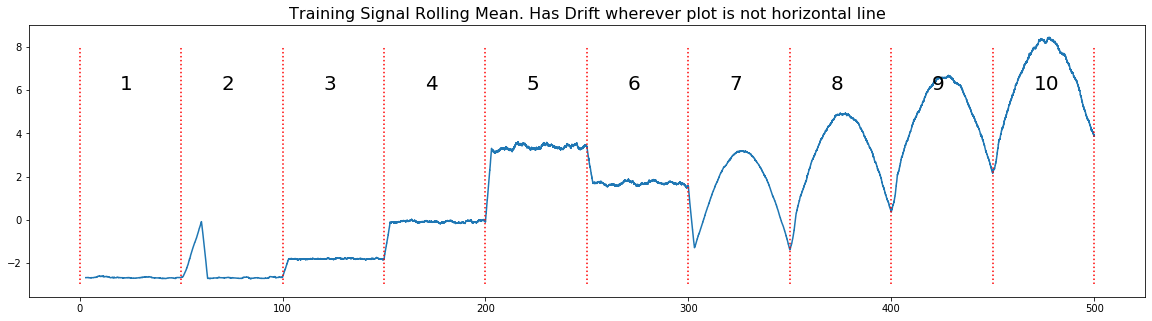

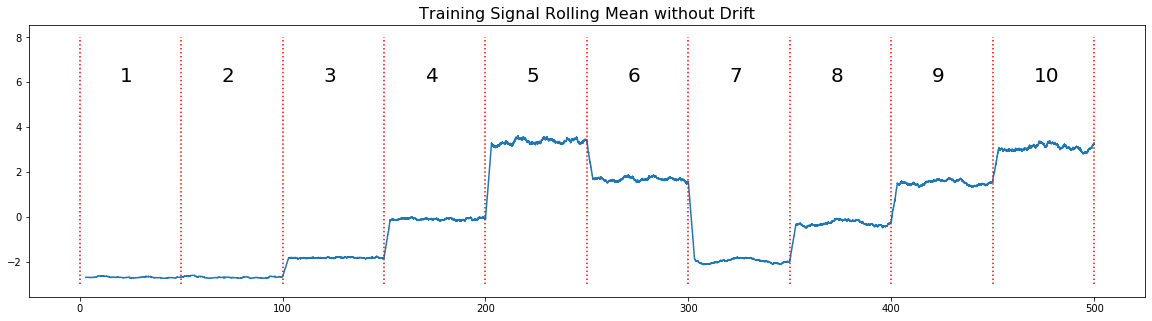

In [68]:
# ORIGINAL TRAIN DATA
plt.figure(figsize=(20,5))
r = train.signal.rolling(30000).mean()
plt.plot(train.time.values,r)
for i in range(11): plt.plot([i*50,i*50],[-3,8],'r:')
for j in range(10): plt.text(j*50+20,6,str(j+1),size=20)
plt.title('Training Signal Rolling Mean. Has Drift wherever plot is not horizontal line',size=16)
plt.show()

# TRAIN DATA WITHOUT DRIFT
plt.figure(figsize=(20,5))
r = train2.signal.rolling(30000).mean()
plt.plot(train2.time.values,r)
for i in range(11): plt.plot([i*50,i*50],[-3,8],'r:')
for j in range(10): plt.text(j*50+20,6,str(j+1),size=20)
plt.title('Training Signal Rolling Mean without Drift',size=16)
plt.show()

## Test Data Drift
We observe drift in test subsamples A, B, E, G, H, I and test batch 3.


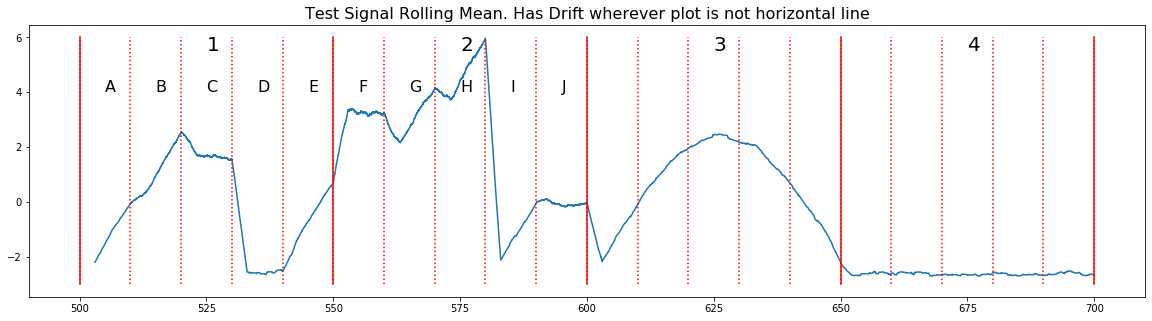

In [69]:
plt.figure(figsize=(20,5))
let = ['A','B','C','D','E','F','G','H','I','J']
r = test.signal.rolling(30000).mean()
plt.plot(test.time.values,r)
for i in range(21): plt.plot([500+i*10,500+i*10],[-3,6],'r:')
for i in range(5): plt.plot([500+i*50,500+i*50],[-3,6],'r')
for k in range(4): plt.text(525+k*50,5.5,str(k+1),size=20)
for k in range(10): plt.text(505+k*10,4,let[k],size=16)
plt.title('Test Signal Rolling Mean. Has Drift wherever plot is not horizontal line',size=16)
plt.show()

# Remove Test Data Drift

In [70]:
test2 = test.copy()

In [71]:
# REMOVE BATCH 1 DRIFT
start=500
a = 0; b = 100000
test2.loc[test2.index[a:b],'signal'] = test2.signal.values[a:b] - 3*(test2.time.values[a:b]-start)/10.
start=510
a = 100000; b = 200000
test2.loc[test2.index[a:b],'signal'] = test2.signal.values[a:b] - 3*(test2.time.values[a:b]-start)/10.
start=540
a = 400000; b = 500000
test2.loc[test2.index[a:b],'signal'] = test2.signal.values[a:b] - 3*(test2.time.values[a:b]-start)/10.

In [72]:
# REMOVE BATCH 2 DRIFT
start=560
a = 600000; b = 700000
test2.loc[test2.index[a:b],'signal'] = test2.signal.values[a:b] - 3*(test2.time.values[a:b]-start)/10.
start=570
a = 700000; b = 800000
test2.loc[test2.index[a:b],'signal'] = test2.signal.values[a:b] - 3*(test2.time.values[a:b]-start)/10.
start=580
a = 800000; b = 900000
test2.loc[test2.index[a:b],'signal'] = test2.signal.values[a:b] - 3*(test2.time.values[a:b]-start)/10.

In [73]:
# REMOVE BATCH 3 DRIFT
def f(x):
    return -(0.00788)*(x-625)**2+2.345 +2.58
a = 1000000; b = 1500000
test2.loc[test2.index[a:b],'signal'] = test2.signal.values[a:b] - f(test2.time[a:b].values)

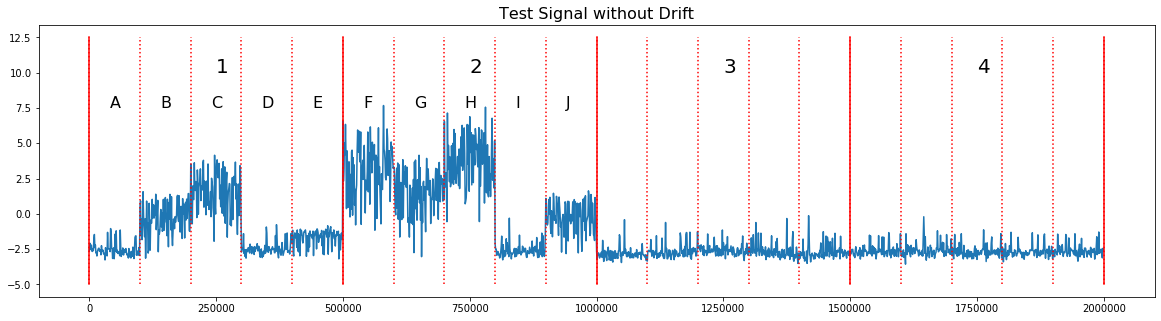

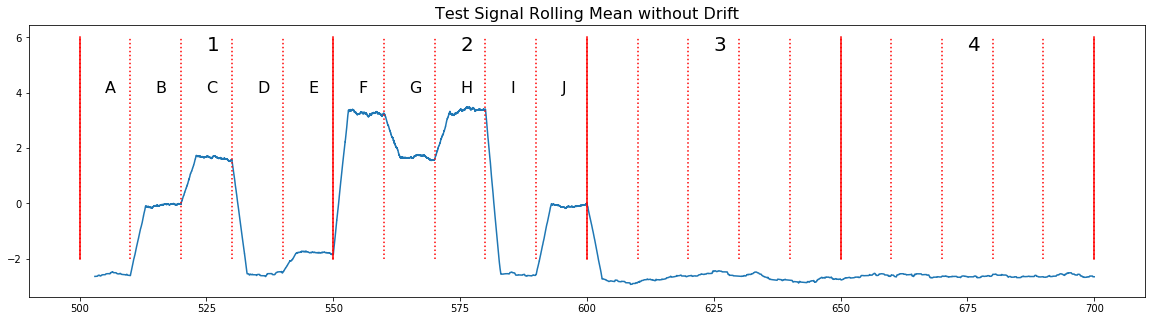

In [74]:
plt.figure(figsize=(20,5))
res = 1000
plt.plot(range(0,test2.shape[0],res),test2.signal[0::res])
for i in range(5): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for i in range(21): plt.plot([i*100000,i*100000],[-5,12.5],'r:')
for k in range(4): plt.text(k*500000+250000,10,str(k+1),size=20)
for k in range(10): plt.text(k*100000+40000,7.5,let[k],size=16)
plt.title('Test Signal without Drift',size=16)
plt.show()

plt.figure(figsize=(20,5))
r = test2.signal.rolling(30000).mean()
plt.plot(test2.time.values,r)
for i in range(21): plt.plot([500+i*10,500+i*10],[-2,6],'r:')
for i in range(5): plt.plot([500+i*50,500+i*50],[-2,6],'r')
for k in range(4): plt.text(525+k*50,5.5,str(k+1),size=20)
for k in range(10): plt.text(505+k*10,4,let[k],size=16)
plt.title('Test Signal Rolling Mean without Drift',size=16)
plt.show()

In [250]:
df_test = divide_and_add_features(test2['signal'])
df_test.head()

100%|██████████| 4/4 [00:49<00:00, 12.40s/it]


,signal,grad_1,grad_2,grad_3,grad_4,lowpass_lf_0.0100,lowpass_ff_0.0100,lowpass_lf_0.0154,lowpass_ff_0.0154,lowpass_lf_0.0239,...,ewm_mean_500,ewm_std_500,ewm_mean_1000,ewm_std_1000,signal_shift_+1,signal_shift_-1,signal_shift_+2,signal_shift_-2,signal_shift_+3,signal_shift_-3
0,-0.176655,-0.013309,0.006300,0.007260,-0.006621,-0.176655,-0.175050,-0.176655,-0.175337,-0.176655,...,-0.176655,0.000000,-0.176655,0.000000,0.000000,-0.189964,0.000000,-0.190673,0.000000,-0.162342
1,-0.189964,-0.007009,0.013560,0.000639,-0.009292,-0.176861,-0.175157,-0.176971,-0.175498,-0.177137,...,-0.183323,0.009411,-0.183316,0.009411,-0.176655,-0.190673,1.000000,-0.162342,1.000000,-0.174377
2,-0.190673,0.013811,0.007578,-0.011324,-0.003742,-0.177278,-0.175253,-0.177603,-0.175633,-0.178090,...,-0.185783,0.007889,-0.185774,0.007893,-0.189964,-0.162342,-0.176655,-0.174377,1.000000,-0.171073
3,-0.162342,0.008148,-0.009088,-0.006846,0.007593,-0.177254,-0.175341,-0.177551,-0.175749,-0.177975,...,-0.179887,0.013391,-0.179898,0.013380,-0.190673,-0.174377,-0.189964,-0.171073,-0.176655,-0.182535
4,-0.174377,-0.004365,-0.006113,0.003861,0.005002,-0.176979,-0.175431,-0.177116,-0.175873,-0.177280,...,-0.178776,0.011846,-0.178789,0.011843,-0.162342,-0.171073,-0.190673,-0.182535,-0.189964,-0.185270


# Predict Test


In [112]:
a = 1
np.unique(clf3.predict(test2.signal.values[100000*a:100000*(a+1)].reshape((-1,1))))

array([0, 1, 2, 3])

In [251]:
sub = pd.read_csv('sample_submission.csv')

a = 0 # SUBSAMPLE A, Model 1s
sub.iloc[100000*a:100000*(a+1),1] = clf1s.predict(df_test[100000*a:100000*(a+1)])

a = 1 # SUBSAMPLE B, Model 3
sub.iloc[100000*a:100000*(a+1),1] = clf3.predict(df_test[100000*a:100000*(a+1)])

a = 2 # SUBSAMPLE C, Model 5
sub.iloc[100000*a:100000*(a+1),1] = clf5.predict(df_test[100000*a:100000*(a+1)])

a = 3 # SUBSAMPLE D, Model 1s
sub.iloc[100000*a:100000*(a+1),1] = clf1s.predict(df_test[100000*a:100000*(a+1)])

a = 4 # SUBSAMPLE E, Model 1f
sub.iloc[100000*a:100000*(a+1),1] = clf1f.predict(df_test[100000*a:100000*(a+1)])

a = 5 # SUBSAMPLE F, Model 10
sub.iloc[100000*a:100000*(a+1),1] = clf10.predict(df_test[100000*a:100000*(a+1)])

a = 6 # SUBSAMPLE G, Model 5
sub.iloc[100000*a:100000*(a+1),1] = clf5.predict(df_test[100000*a:100000*(a+1)])

a = 7 # SUBSAMPLE H, Model 10
sub.iloc[100000*a:100000*(a+1),1] = clf10.predict(df_test[100000*a:100000*(a+1)])

a = 8 # SUBSAMPLE I, Model 1s
sub.iloc[100000*a:100000*(a+1),1] = clf1s.predict(df_test[100000*a:100000*(a+1)])

a = 9 # SUBSAMPLE J, Model 3
sub.iloc[100000*a:100000*(a+1),1] = clf3.predict(df_test[100000*a:100000*(a+1)])

 # BATCHES 3 AND 4, Model 1s
sub.iloc[1000000:2000000,1] = clf1s.predict(df_test[1000000:2000000])

# Display Test Predictions

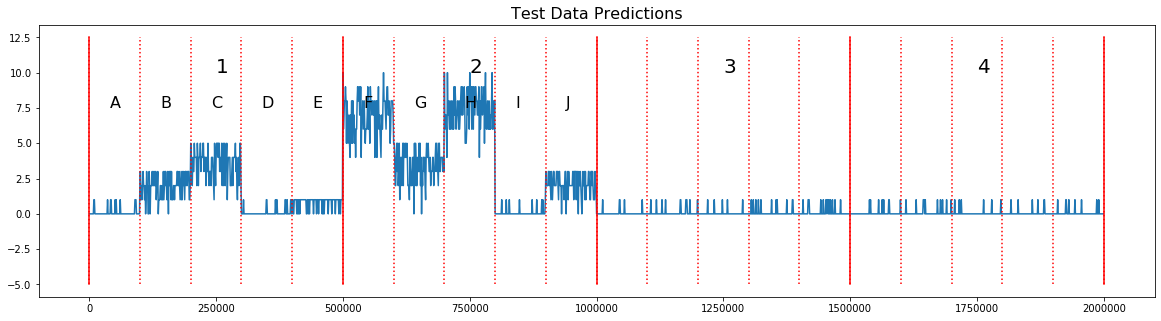

In [252]:
plt.figure(figsize=(20,5))
res = 1000
plt.plot(range(0,test.shape[0],res),sub.open_channels[0::res])
for i in range(5): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for i in range(21): plt.plot([i*100000,i*100000],[-5,12.5],'r:')
for k in range(4): plt.text(k*500000+250000,10,str(k+1),size=20)
for k in range(10): plt.text(k*100000+40000,7.5,let[k],size=16)
plt.title('Test Data Predictions',size=16)
plt.show()

In [253]:
score_mean = np.mean([score_1s, score_1f, score_3, score_5, score_10])
sub.to_csv(f'submission_{score_mean:.4f}.csv',index=False,float_format='%.4f')

In [254]:
score_mean

0.9505386936615974

In [225]:
score_mean

0.925771278688968